## Install LAMP package

In [4]:
! pip install LAMP-core

Processing ./.cache/pip/wheels/d8/5c/0e/de70819883a77b14d40e6733397641c6d1f467625db988fea6/LAMP_core-1.0.4-py3-none-any.whl


## Configure

##### In order to access data via the LAMP API, you must enter your credentials. 

##### Data from the college studies is split into two Researcher profiles, each with its own ID and its own set of credentials. After connecting to one profile with its credentials, you must reconnect with credentials for the second profile in order to access data from the latter profile (and vice versa).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pdb
from tqdm import tqdm
import math
from matplotlib.ticker import FormatStrFormatter

In [2]:
import LAMP

#connect to first profile
LAMP.connect("maurice.smith.one@lamp.com", "maurice.smith.one")
RESEARCHER_ONE = "UmVzZWFyY2hlcjoxMDE3NQ~~" #id for first profile

#Get all participants belonging to 'RESEARCHER_ONE'
PARTICIPANTS_ONE = LAMP.Participant.all_by_researcher(RESEARCHER_ONE)
PARTICIPANTS_ONE['data'][:5]

[{'id': 'U7670518187'},
 {'id': 'U2661178286'},
 {'id': 'U4531292280'},
 {'id': 'U4983481846'},
 {'id': 'U0770408801'}]

In [3]:
#connect to second profile
LAMP.connect("maurice.smith.two@lamp.com", "maurice.smith.two")
RESEARCHER_TWO = "UmVzZWFyY2hlcjoxMDE3Ng~~" #id for second profile

PARTICIPANTS_TWO = LAMP.Participant.all_by_researcher(RESEARCHER_TWO)
PARTICIPANTS_TWO['data'][:5]

[{'id': 'U1073731569'},
 {'id': 'U9968932692'},
 {'id': 'U2769635690'},
 {'id': 'U1758781382'},
 {'id': 'U4654996845'}]

## Query accelerometer data

##### Accelerometer data points are SensorEvents with the origin "lamp.accelerometer". 


##### See LAMP-py documentation at https://github.com/BIDMCDigitalPsychiatry/LAMP-py for further API details.

In [198]:
i_subj = 1;
pp = PARTICIPANTS_TWO['data'][i_subj]['id'];
survey = LAMP.ActivityEvent.all_by_participant(participant)['data'];
nexttime = survey[0]['timestamp'];

while(nexttime>survey[-1]['timestamp']):
    # Retrieve data counting backwards from start of survey
    kk = LAMP.SensorEvent.all_by_participant(participant, origin="lamp.accelerometer", to=survey[0]['timestamp']);
    
    # Update time
    nexttime = kk['data'][-1]['timestamp'];
    
    # 
    
kk2 = LAMP.SensorEvent.all_by_participant(participant, origin="lamp.accelerometer", to=nexttime);
nexttime = kk2['data'][-1]['timestamp'];
kk3 = LAMP.SensorEvent.all_by_participant(participant, origin="lamp.accelerometer", to=nexttime);

st2=survey[-1]['timestamp']; ending2 = survey[0]['timestamp'];
print(f'survey start:{st2}, end: {ending2}');

print('------------------- kk -------------------');
st = kk['data'][-1]['timestamp']; ending = kk['data'][0]['timestamp'];
print(f'data  start: {st}, end: {ending}');


print('------------------- kk2 --------------------');
st = kk2['data'][-1]['timestamp']; ending = kk2['data'][0]['timestamp'];
print(f'data  start: {st}, end: {ending}');

print('------------------- kk3 --------------------');
st = kk3['data'][-1]['timestamp']; ending = kk3['data'][0]['timestamp'];
print(f'data  start: {st}, end: {ending}');

xx=np.array(kk['data']); xx2=np.array(kk2['data']);
print(len(xx)); print(len(xx2)); print(len(kk['data']))
print(xx[-1]); 
print('------------------xxx-------------------');
print(xx2[0]);
# xx.append(xx2);
xxall = np.hstack((xx,xx2))
print(len(xxall));
# print(xx[0]);
# print('------------------xxx-------------------');
# print(xx[-1])

survey start:1591834125000, end: 1593359689000
------------------- kk -------------------
data  start: 1592759423646, end: 1593359310891
------------------- kk2 --------------------
data  start: 1592064370665, end: 1592758823661
------------------- kk3 --------------------
data  start: 1591800800513, end: 1592063770666
1000
1000
1000
{'timestamp': 1592759423646, 'sensor': 'lamp.accelerometer', 'data': {'x': 0.0081787109375, 'y': -0.0120697021484375, 'z': -1.0092926025390625}}
------------------xxx-------------------
{'timestamp': 1592758823661, 'sensor': 'lamp.accelerometer', 'data': {'x': 0.000518798828125, 'y': -0.111480712890625, 'z': -1.00439453125}}
2000


In [113]:
nsubj=82; #this needs to be determined beforehand
participant_accel = [dict() for i in range(nsubj)]
for i in tqdm(range(82),position=0,leave=True):#len(PARTICIPANTS_TWO['data'])):
    participant = PARTICIPANTS_TWO['data'][i]['id']; #First participant
    survey = LAMP.ActivityEvent.all_by_participant(participant)['data'];

    if len(survey)>0:
        participant_accel[i] = LAMP.SensorEvent.all_by_participant(
            participant, origin="lamp.accelerometer", _from=survey[-1]['timestamp'], to=survey[0]['timestamp']);
    else:
        participant_accel[i] = LAMP.SensorEvent.all_by_participant(participant, origin="lamp.accelerometer");
    
print(len(participant_accel))

100%|██████████| 82/82 [00:26<00:00,  2.20it/s]

82


### Explore accelerometer data: 
###### (a) Explore time stamps, sampling interval
###### (b) Explore acceleration in x, y, z and overall

In [114]:
# Plot x,y,z acceleration for participants
tt=np.empty(shape=(nsubj,4),dtype='object'); # Variable length array for each participant
ndays=np.empty(shape=(nsubj));
for isubj in range(nsubj):
    lt = len(participant_accel[isubj]['data']);
    tt[isubj,:] = [np.empty(shape=(lt,1)) for _ in range(4)]
    for it in range(lt):
        tt[isubj,0][it] = participant_accel[isubj]['data'][it]['timestamp'];
        tt[isubj,1][it] = participant_accel[isubj]['data'][it]['data']['x'];
        tt[isubj,2][it] = participant_accel[isubj]['data'][it]['data']['y'];
        tt[isubj,3][it] = participant_accel[isubj]['data'][it]['data']['z'];
    if lt>0:
        ndays[isubj] = np.abs(tt[isubj,0][lt-1] - tt[isubj,0][0])/(600000*6*24); #ndays = [max(timestamp) - min(timestamp)]/(6*24)
    
which_subj=0;
f=plt.figure(figsize=(15,5));
plt.subplot(131); plt.plot(tt[which_subj,0]); plt.title(f'Timestamp ({ndays[which_subj]:.2f} days)');
plt.subplot(132); plt.plot(np.diff(tt[which_subj,0],axis=0)); plt.title('Diff(timestamp)')
plt.subplot(133); plt.hist(np.diff(tt[which_subj,0],axis=0),bins=100); 
plt.title(f'Mean: {np.mean(np.diff(tt[which_subj,0],axis=0))}, IQR: {stats.iqr(np.diff(tt[which_subj,0],axis=0))}')
plt.suptitle(f'Subject {which_subj:d}',fontsize=15);
plt.savefig(f'Exploration/Time_subj{which_subj:d}')
plt.show();

coord='XYZ';
f=plt.figure(figsize=(15,5));
for i in range(3):
    plt.subplot(1,3,i+1); plt.plot(tt[which_subj,0],tt[which_subj,i+1]); plt.title(coord[i]); plt.xlabel('timestamp')
    plt.xticks(rotation='vertical')
    
plt.savefig(f'Exploration/Rawdata_subj{which_subj:d}')

/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


11


<Figure size 504x360 with 0 Axes>

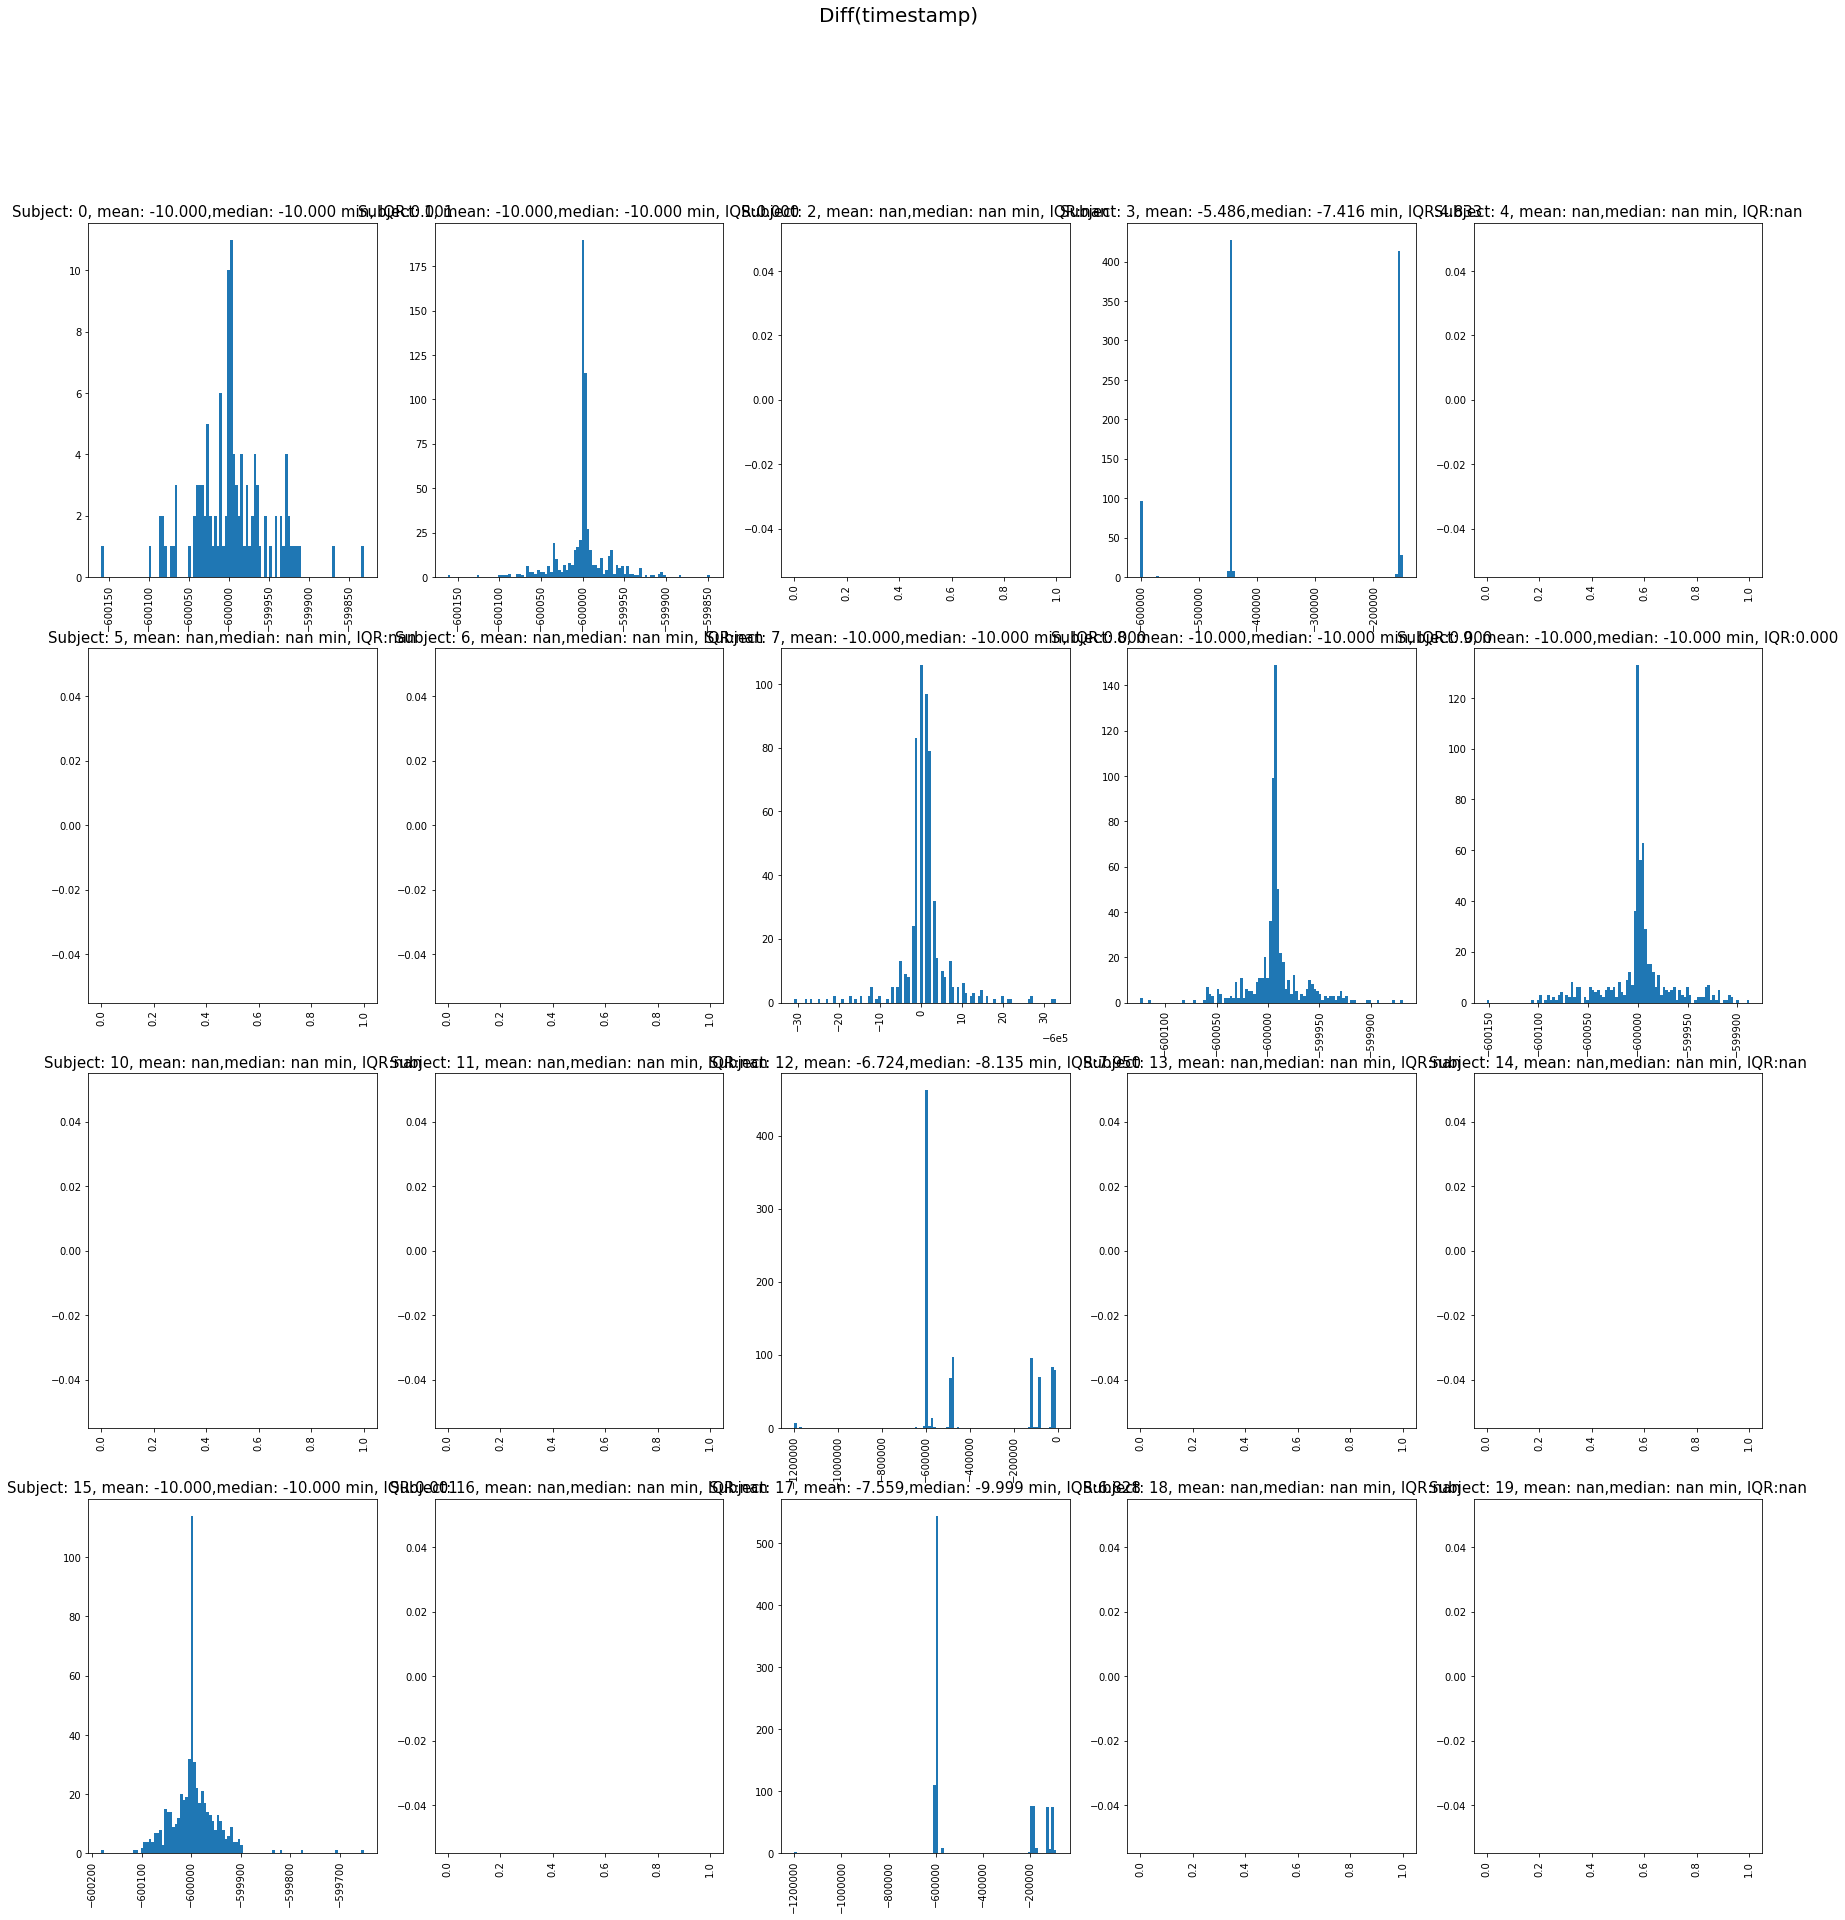

22


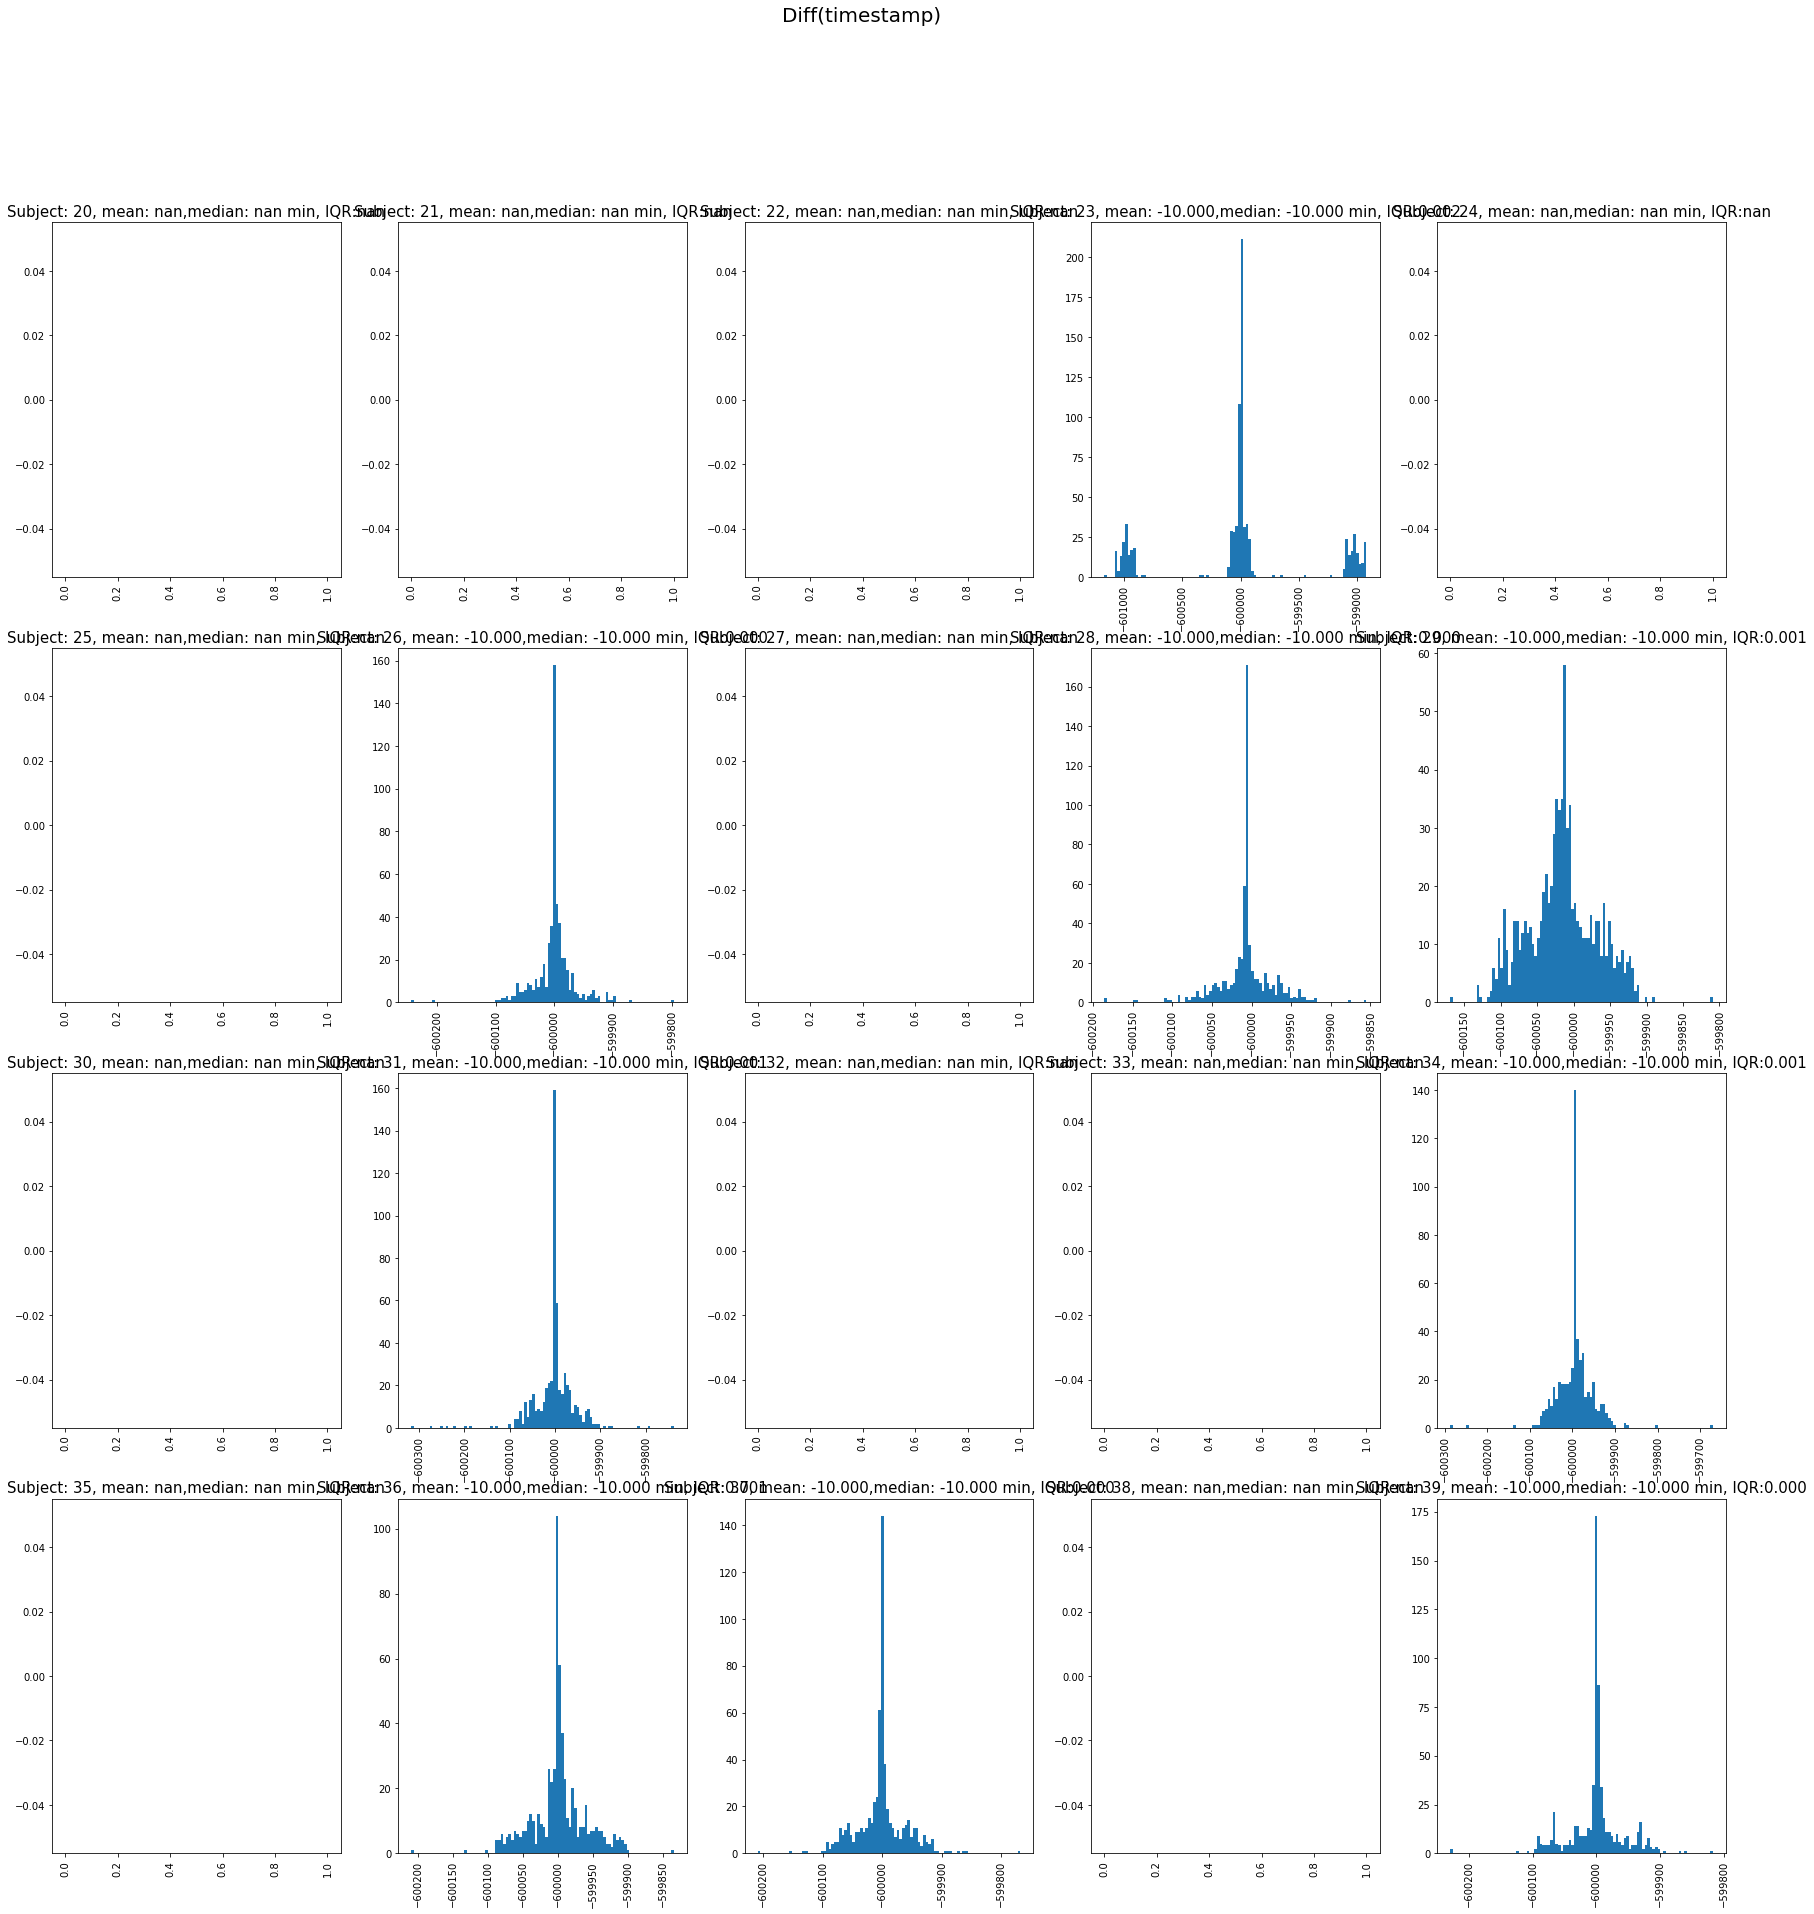

40


51


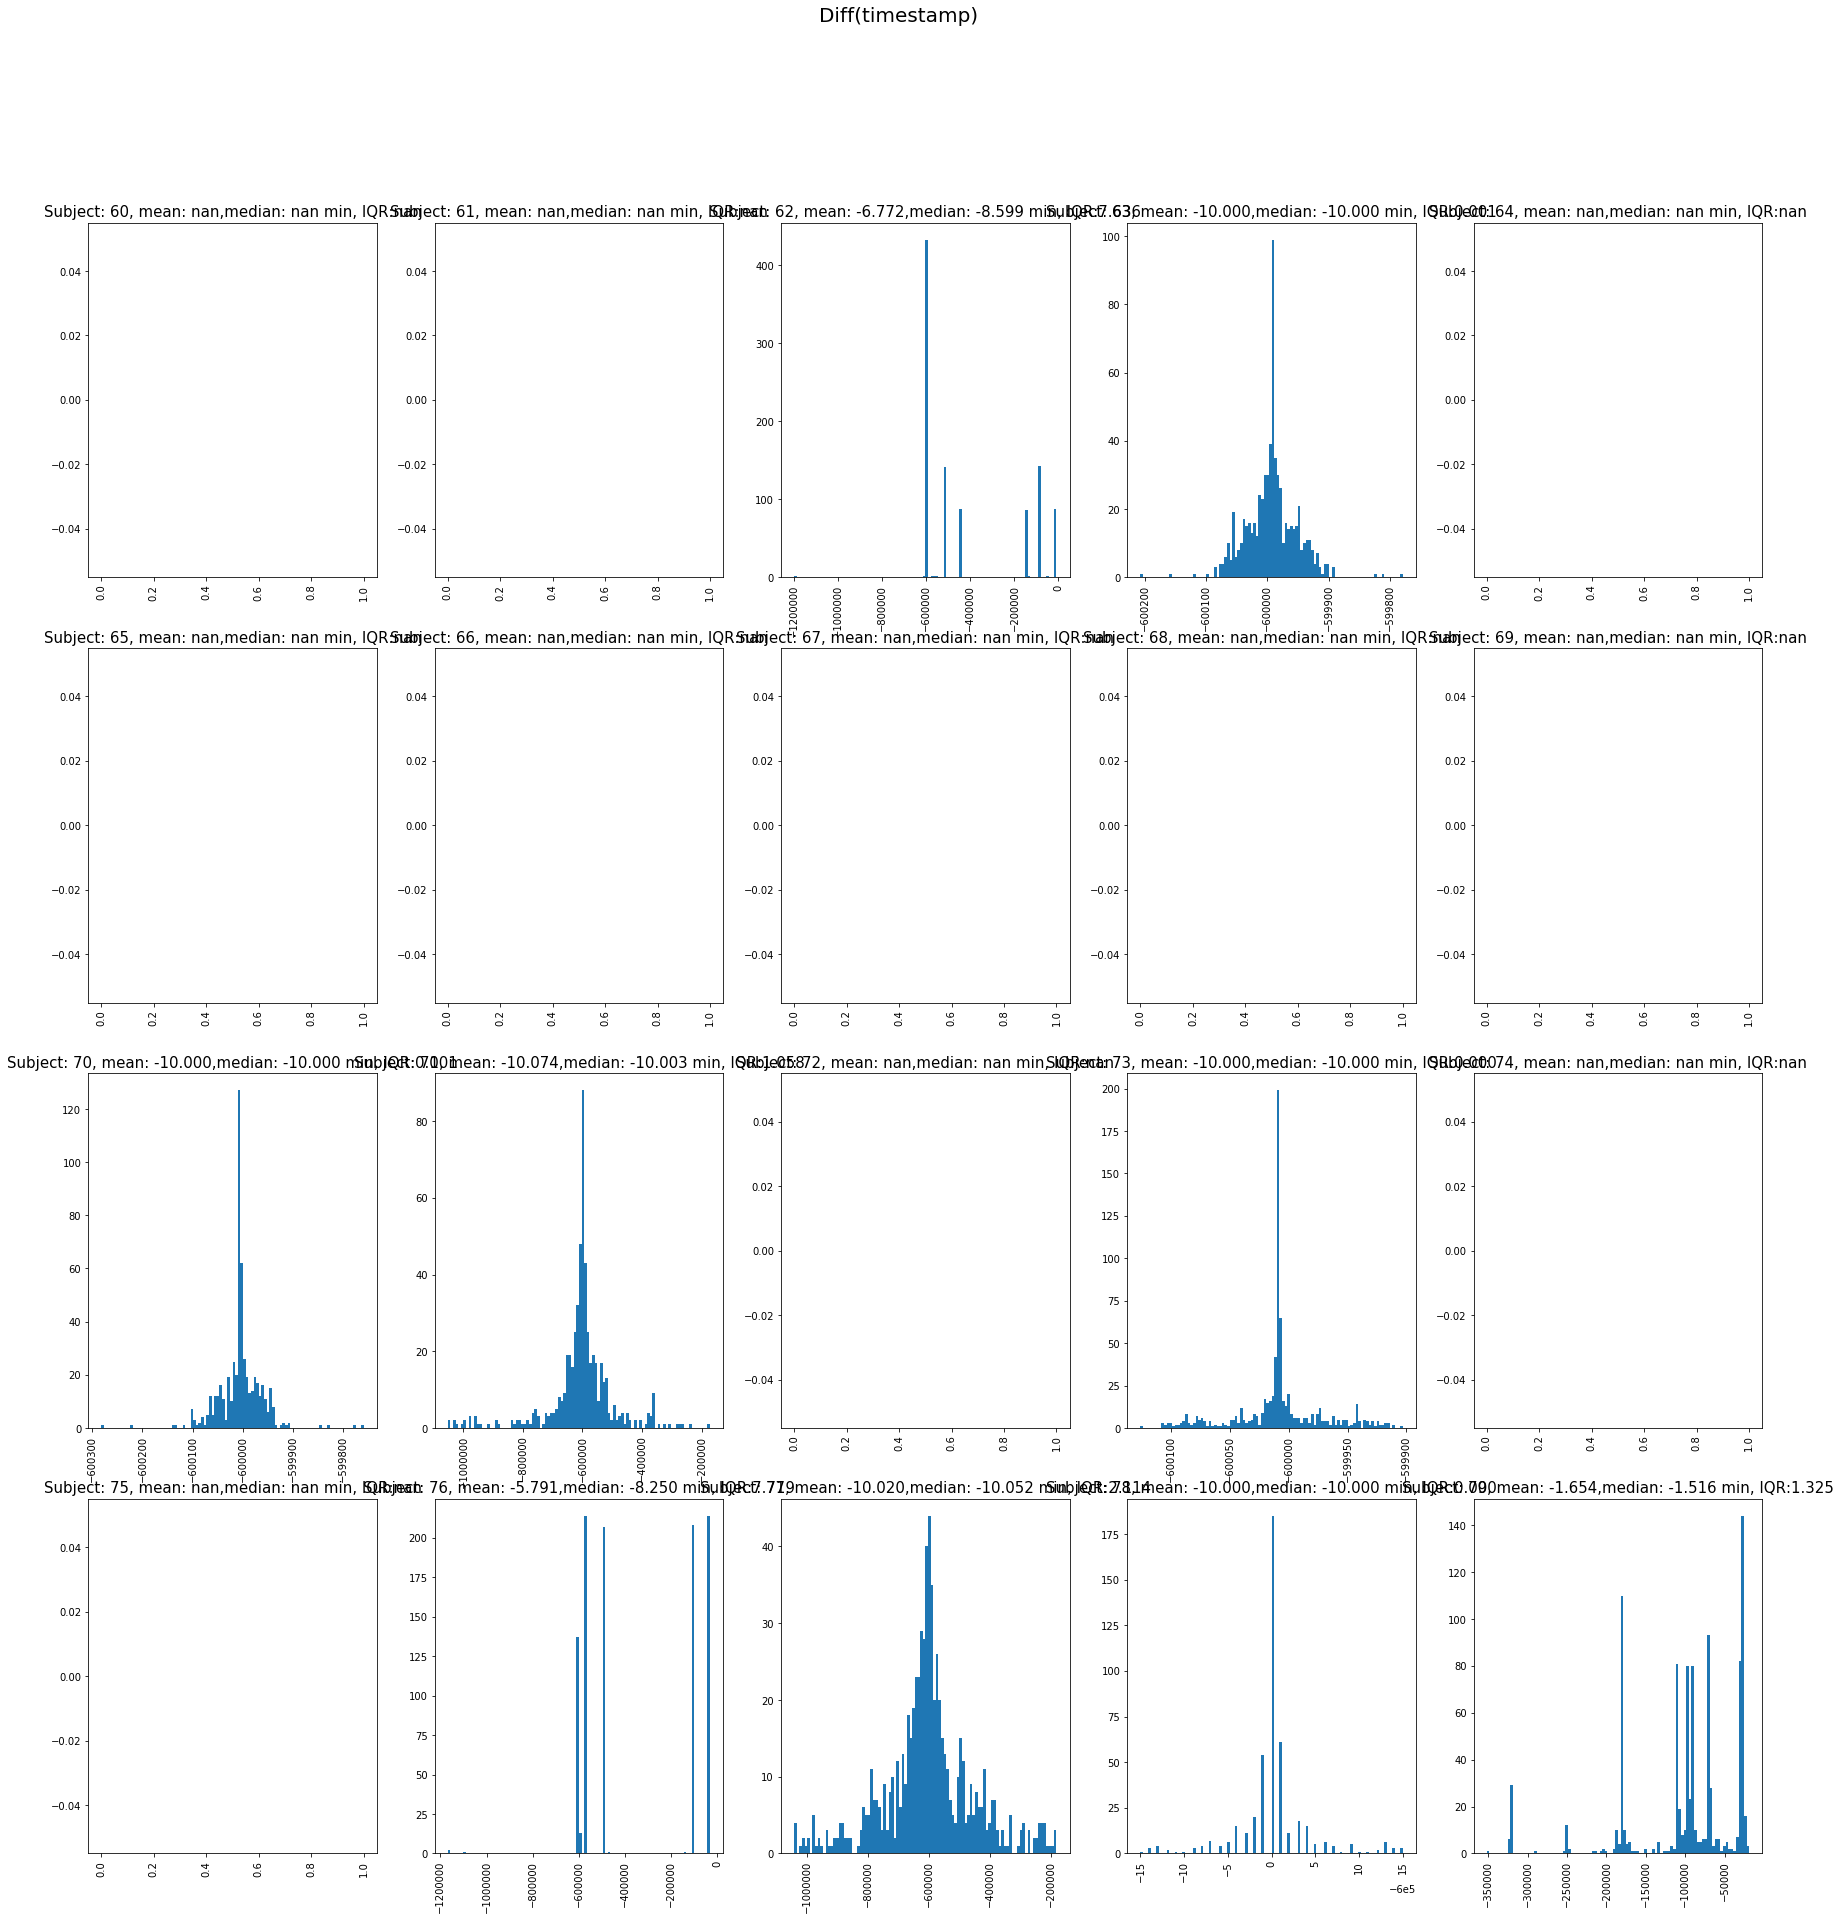

52


52


In [80]:
# Sampling rate for all participants
niqr=500;
nodata=0;
st_data = np.empty(shape=(nsubj,5)); #Nsamples, mean, median, std, iqr
f2=plt.figure(figsize=(7,5));
for i in range(5): 
    f=plt.figure(figsize=(30,30));
    for i_subj in range(i*20,np.min([(i+1)*20,nsubj])):
        kk = np.diff(tt[i_subj,0],axis=0); kk[np.abs(kk-np.median(kk))>2.5*stats.iqr(kk)]=float('nan')
        plt.subplot(4,5,i_subj+1-(i*20)); plt.hist(kk,bins=100);
        
        iqq=stats.iqr(kk,nan_policy='omit')/(1000*60); #need to do this separately before the title
        st_data[i_subj,:]=np.array([len(tt[i_subj,0]),np.nanmean(kk),np.nanmedian(kk),np.nanstd(kk),iqq])
        plt.title(f'Subject: {i_subj:d}, mean: {np.nanmean(kk)/(1000*60):0.3f},median: {np.nanmedian(kk)/(1000*60):0.3f} min, IQR:{iqq:0.3f}',fontsize=15);
        
        if math.isnan(np.nanmedian(kk)):
            nodata = nodata + 1;
        
        plt.xticks(rotation='vertical')
    plt.suptitle('Diff(timestamp)',fontsize=20); 
    print(nodata)
    plt.savefig(f'Exploration/sampling_rate_{i*20:d}_to_{np.min([(i+1)*20,nsubj]):d}')
    plt.show();

print(nodata) 




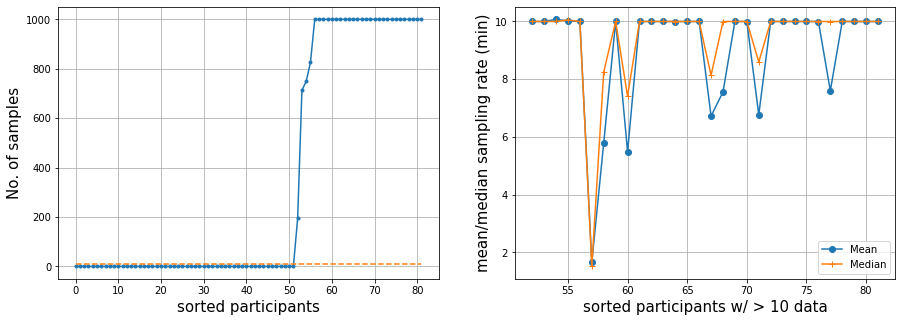

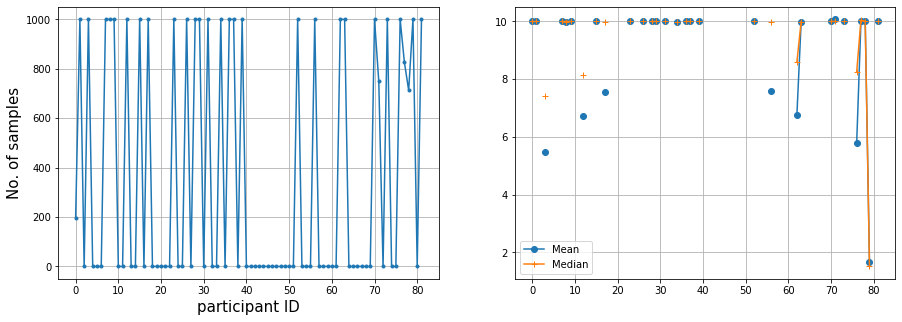

In [115]:
# Plot mean and median sampling rates for all participants over a certain threshold
thresh_nsample=10;
st_data[st_data[:,0]<thresh_nsample,1:] = float('nan')
sorted_idx = np.argsort(st_data[:,0],axis=0);

f=plt.figure(figsize=(15,5));
plt.subplot(1,2,1); plt.plot(st_data[sorted_idx,0],'.-'); plt.plot(st_data[:,0]*0+thresh_nsample,'--'); 
plt.xlabel('sorted participants',fontsize=15); plt.ylabel('No. of samples',fontsize=15); plt.grid();

plt.subplot(1,2,2); plt.plot(-st_data[sorted_idx,1]/(1000*60),'o-',label='Mean');
plt.plot(-st_data[sorted_idx,2]/(1000*60),'+-',label='Median'); plt.ylabel(f'mean/median sampling rate (min)',fontsize=15)
plt.xlabel(f'sorted participants w/ > {thresh_nsample:d} data',fontsize=15); plt.grid()
plt.legend();

plt.savefig('Exploration/mean_sampling_rate.png')
plt.show();

f=plt.figure(figsize=(15,5));
plt.subplot(1,2,1); plt.plot(st_data[:,0],'.-'); plt.ylabel('No. of samples',fontsize=15);plt.xlabel('participant ID',fontsize=15); plt.grid();
plt.subplot(1,2,2); plt.plot(-st_data[:,1]/(1000*60),'o-',label='Mean'); plt.plot(-st_data[:,2]/(1000*60),'+-',label='Median');
plt.grid(); plt.legend();
plt.show();


In [116]:
# Get indices of participants with >thresh_nsample data points
idx_d = np.where(st_data[:,0]>thresh_nsample)[0];
print(idx_d)

[ 0  1  3  7  8  9 12 15 17 23 26 28 29 31 34 36 37 39 52 56 62 63 70 71
 73 76 77 78 79 81]


### Count hours with no change in accelerometer data
###### (a) z-score readings from each dimension
###### (b) Get net accelerometer data
###### (c) Identify sleep periods
###### (d) Match (a) to (b)

In [117]:
#z-score x, y, z
tt_=np.empty_like(tt);
for isubj in range(nsubj):
    tt_[isubj,0] = tt[isubj,0];
    tt_[isubj,1] = stats.zscore(tt[isubj,1]);
    tt_[isubj,2] = stats.zscore(tt[isubj,2]);
    tt_[isubj,3] = stats.zscore(tt[isubj,3]);

which_subj=idx_d[7];
f=plt.figure(figsize=(15,5))
for i in range(1,4):
    plt.subplot(1,3,i); plt.plot(tt[which_subj,0], tt[which_subj,i],label='raw'); 
    plt.plot(tt_[which_subj,0], tt_[which_subj,i],label='z-scored'); plt.xlabel('Timestamp'); plt.xticks(rotation='vertical')
    plt.title(coord[i-1])
plt.suptitle(f'Subject: {which_subj:d}',fontsize=15); plt.legend(); 
plt.savefig(f'Exploration/z-scored_subj{which_subj:d}')
plt.show();

In [118]:
# Get magnitude of net accelerometer data
tot_acc = np.empty(shape=(nsubj),dtype='object')
for isubj in range(nsubj):
    tot_acc[isubj] = np.empty(shape=(len(tt_[isubj,1]))); #pdb.set_trace();
    tot_acc[isubj] = np.sqrt(tt_[isubj,1]**2 + tt_[isubj,2]**2 + tt_[isubj,3]**2);
plt.plot(tt_[which_subj,0],tot_acc[which_subj]); plt.title(f'Net acceleration from z-scored data, Subject: {which_subj:d}'); 
plt.xticks(rotation='vertical'); plt.xlabel('Timestamp'); plt.savefig(f'Exploration/netacc_subj{which_subj:d}'); plt.show()

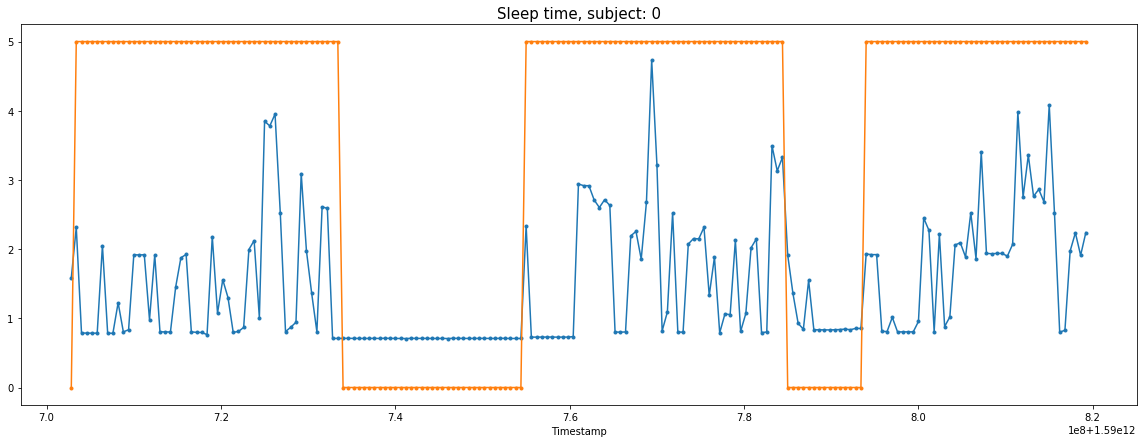

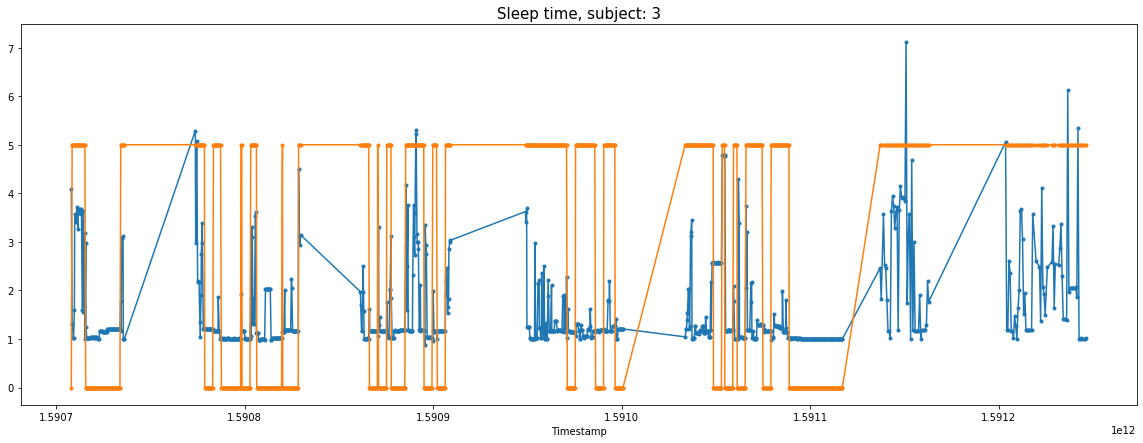

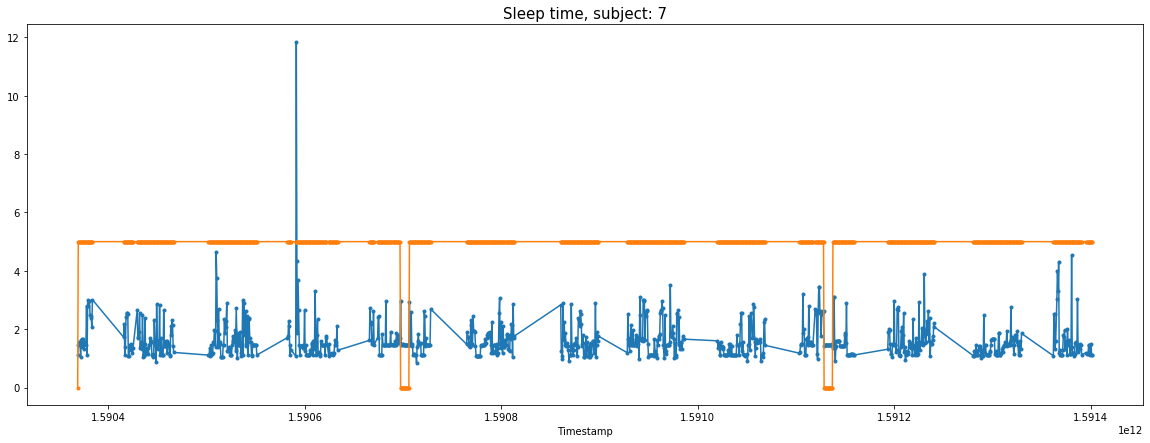

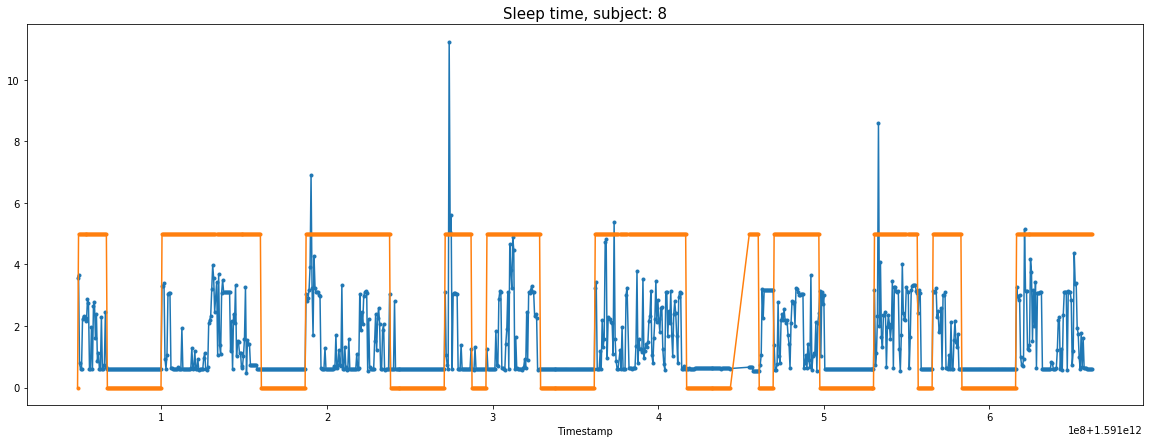

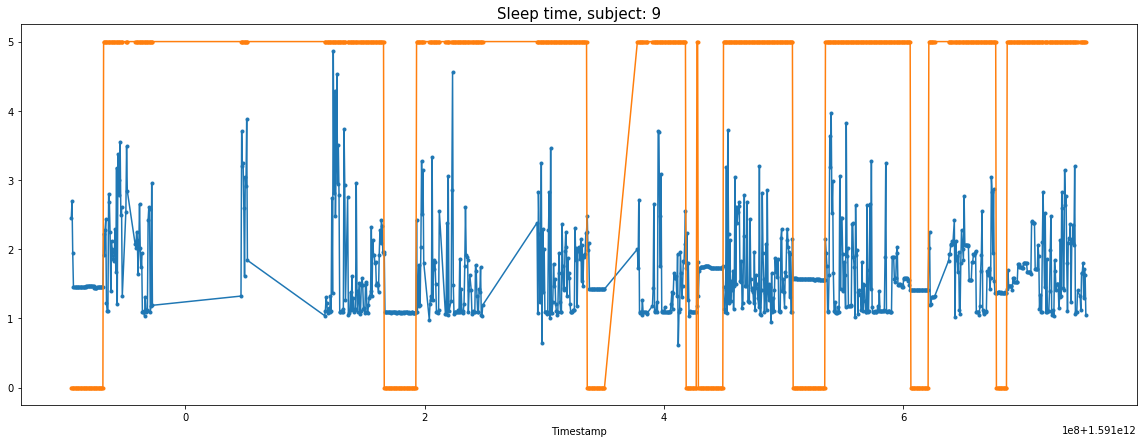

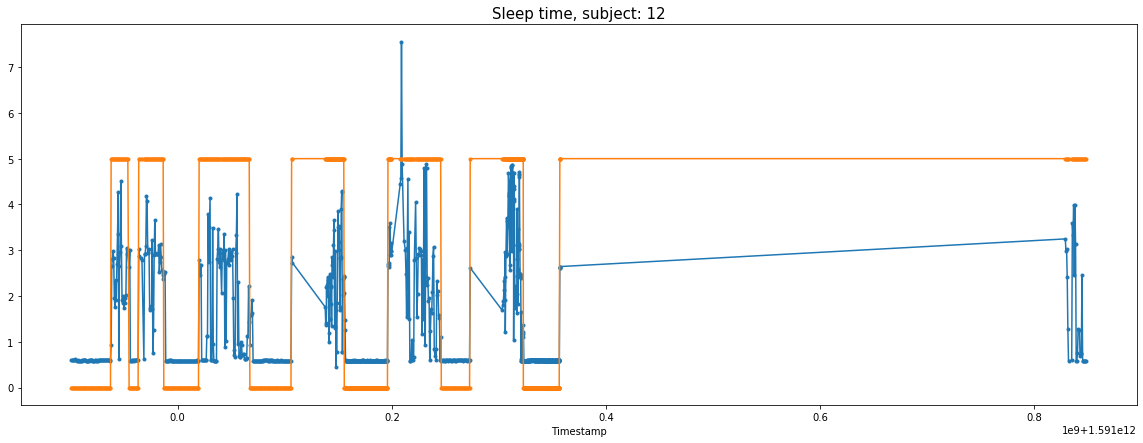

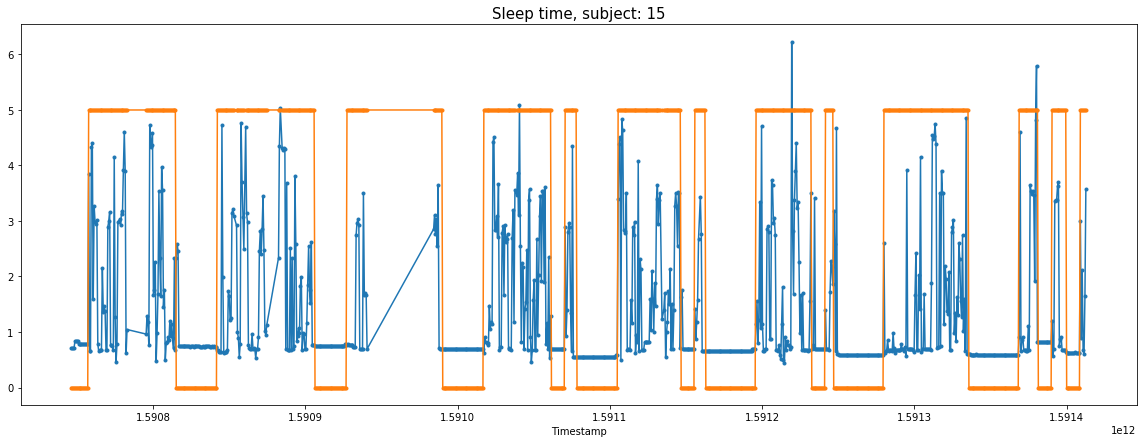

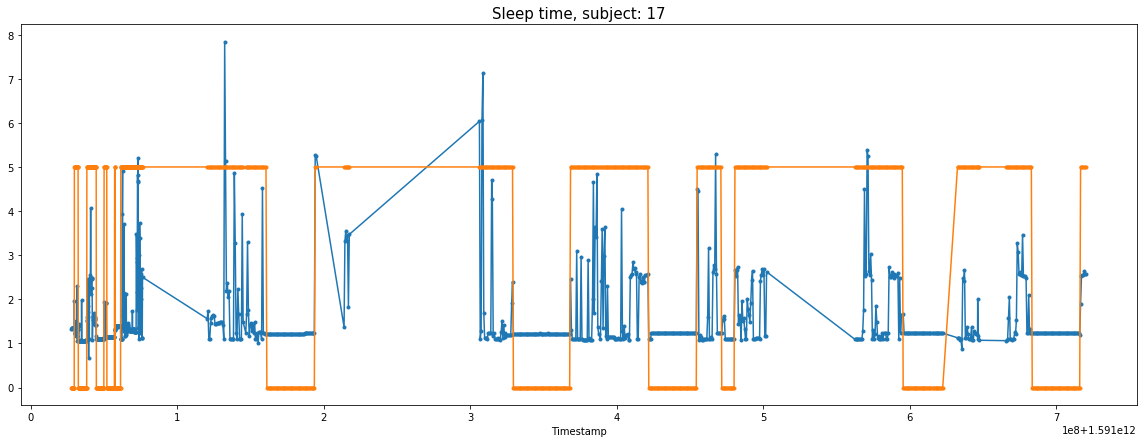

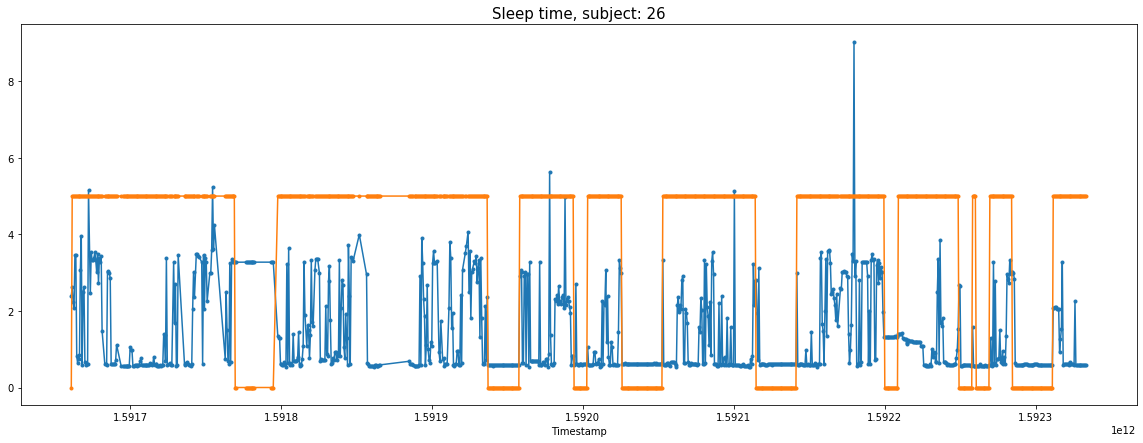

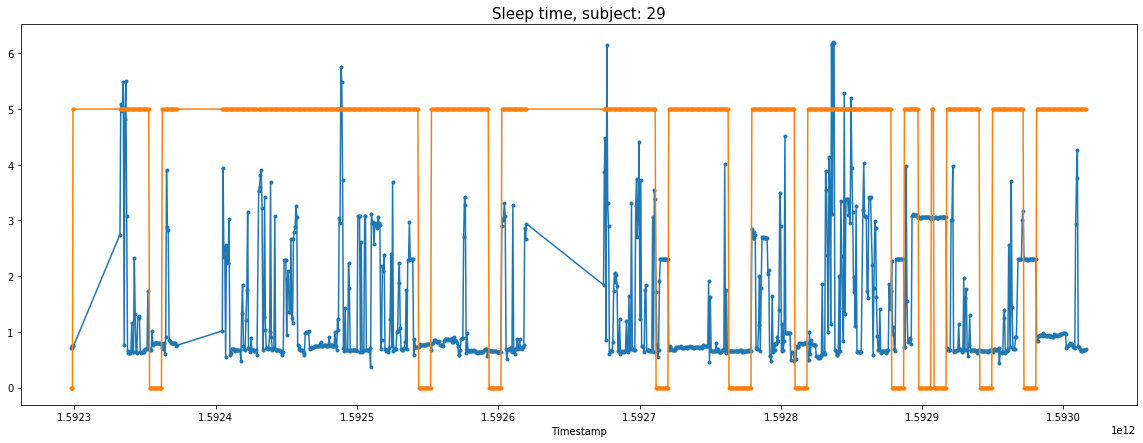

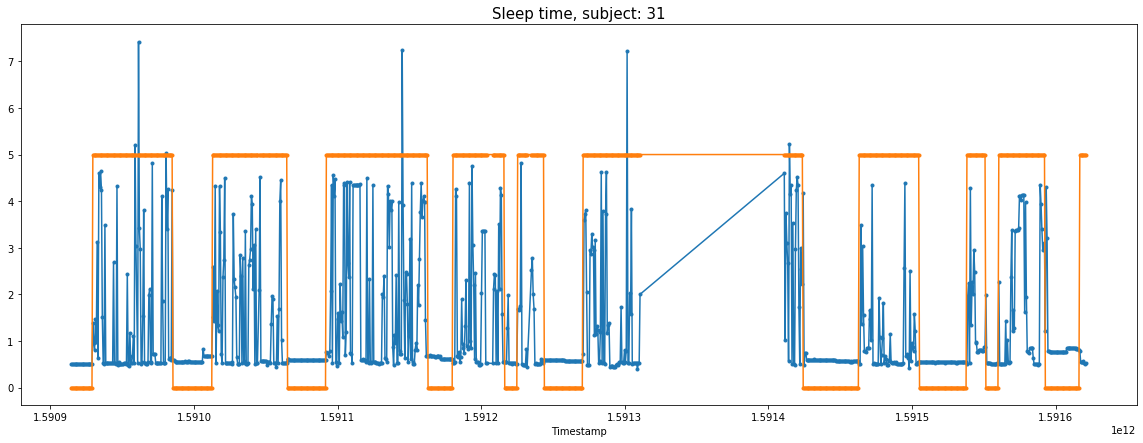

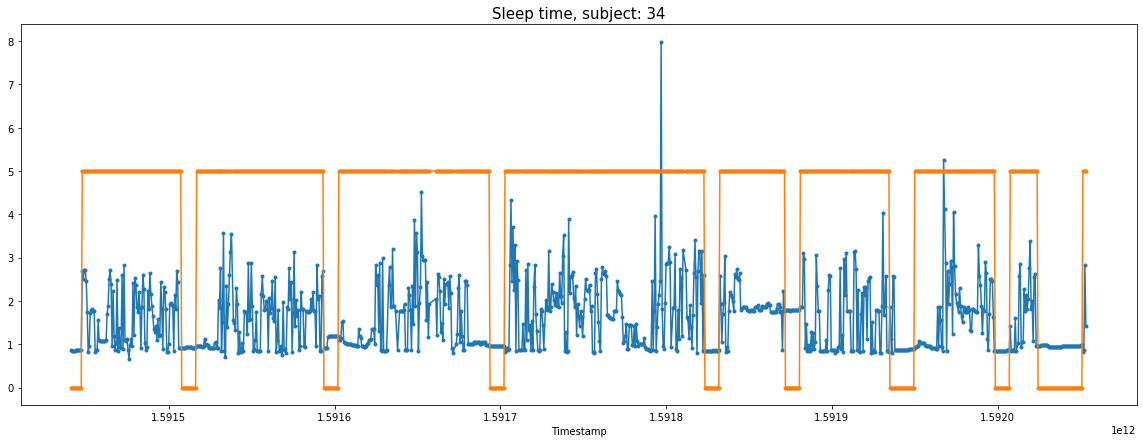

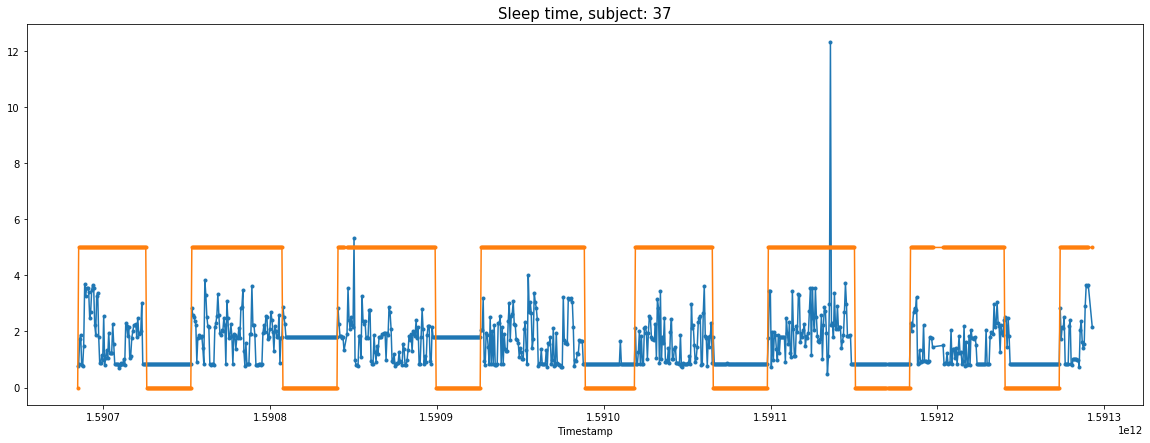

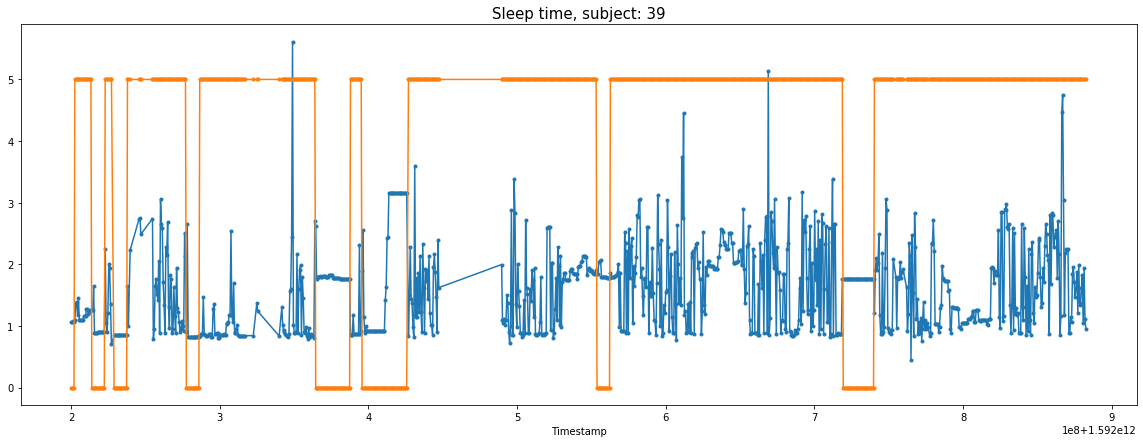

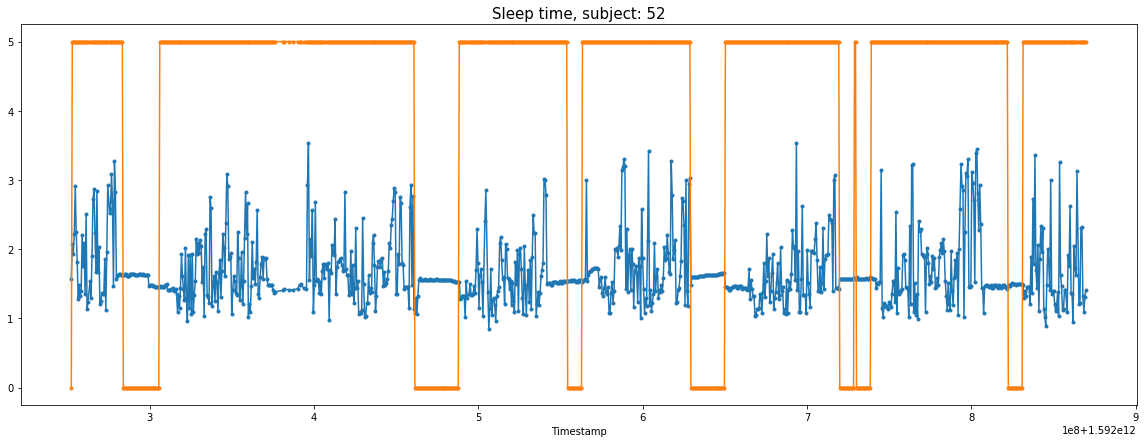

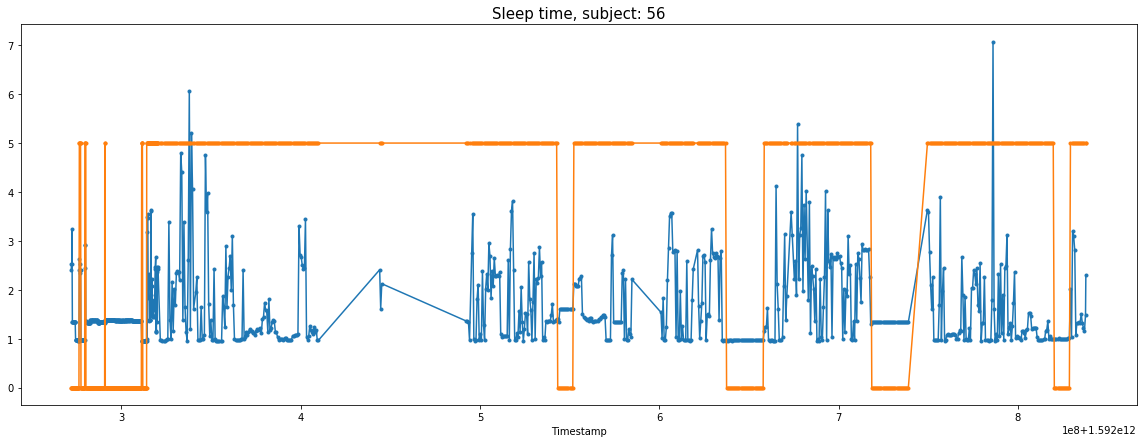

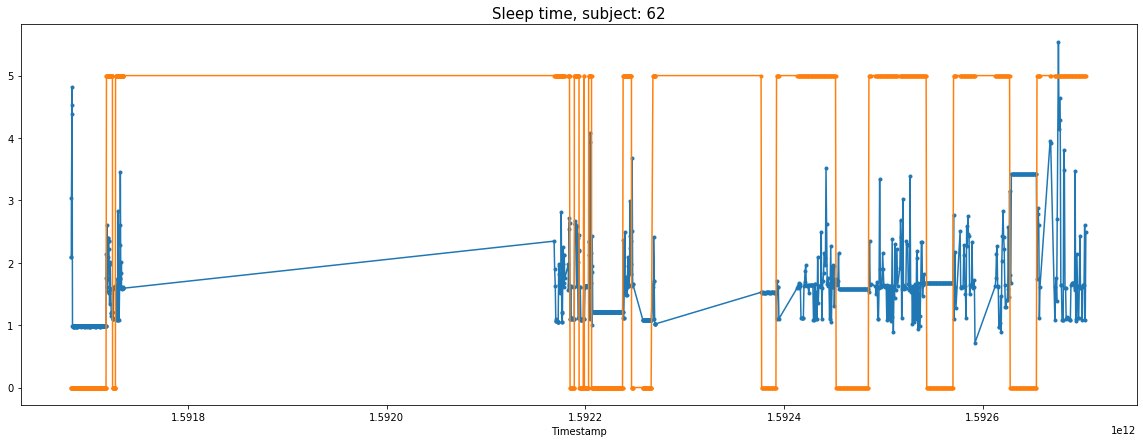

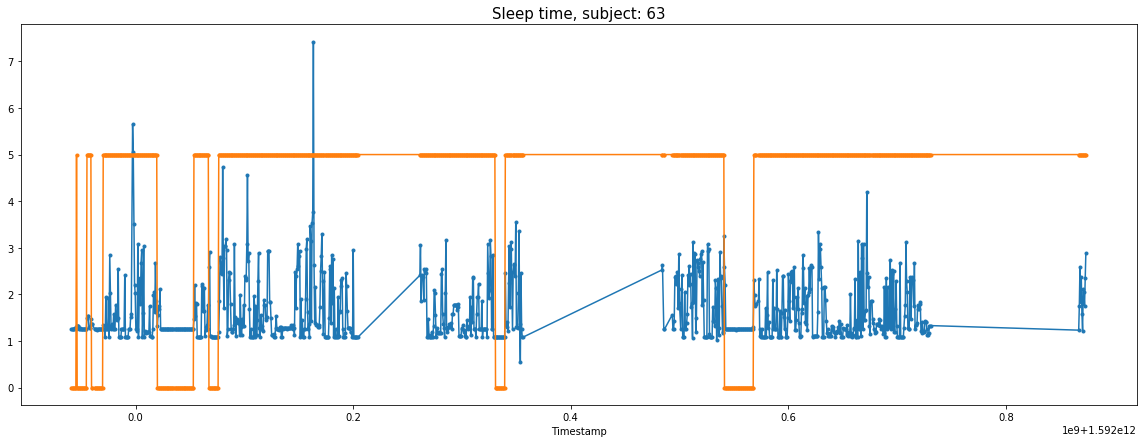

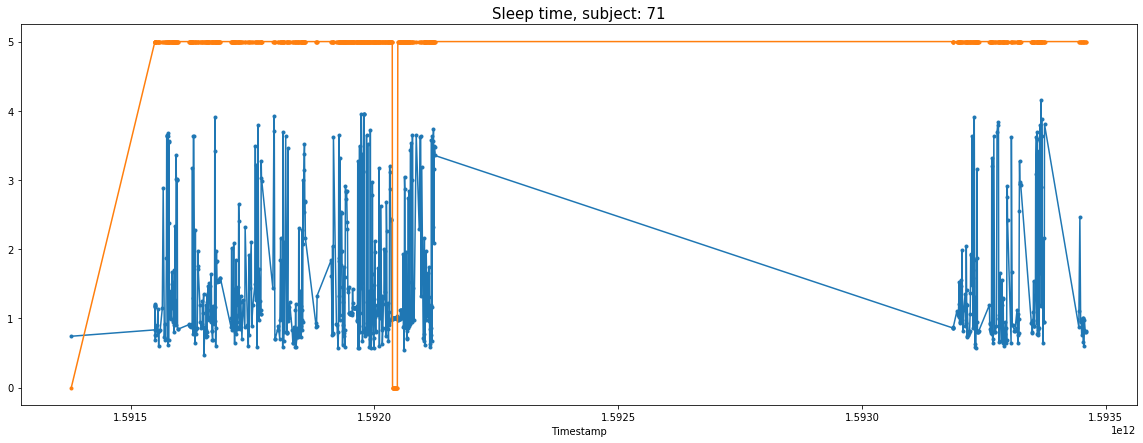

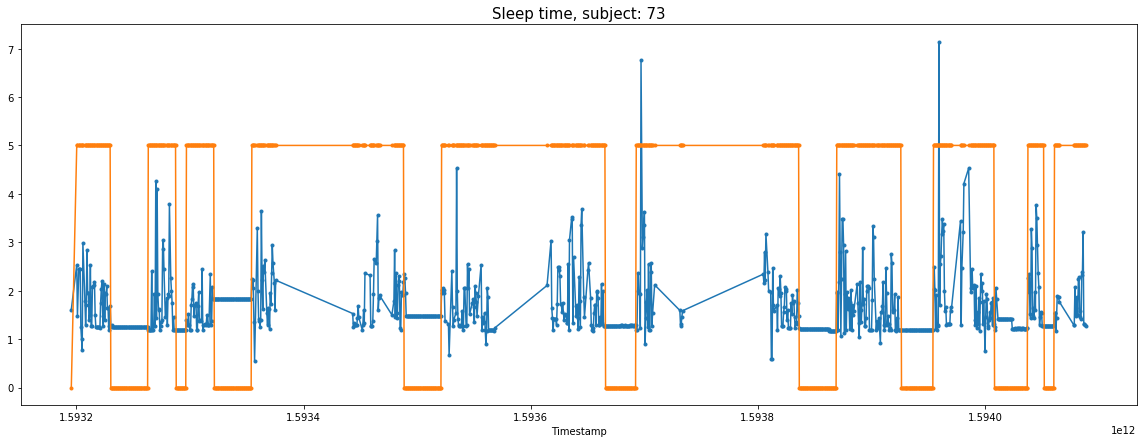

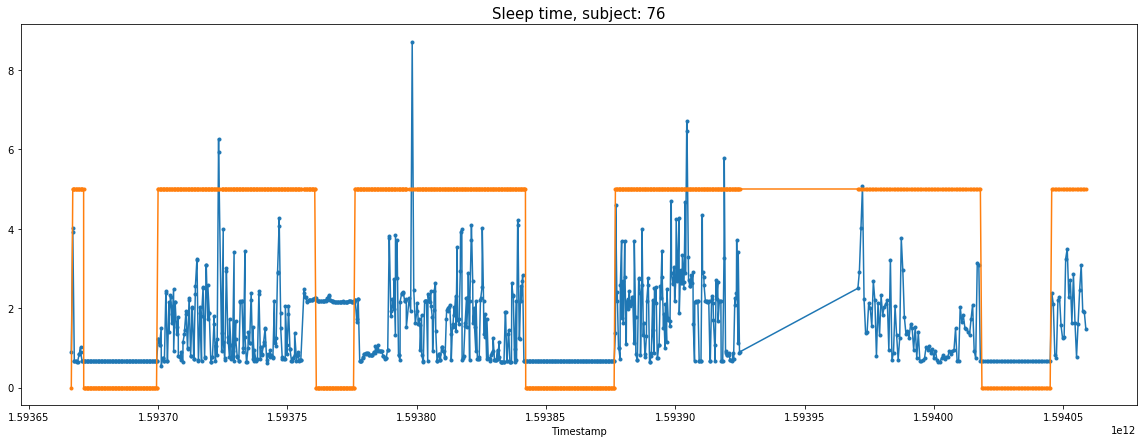

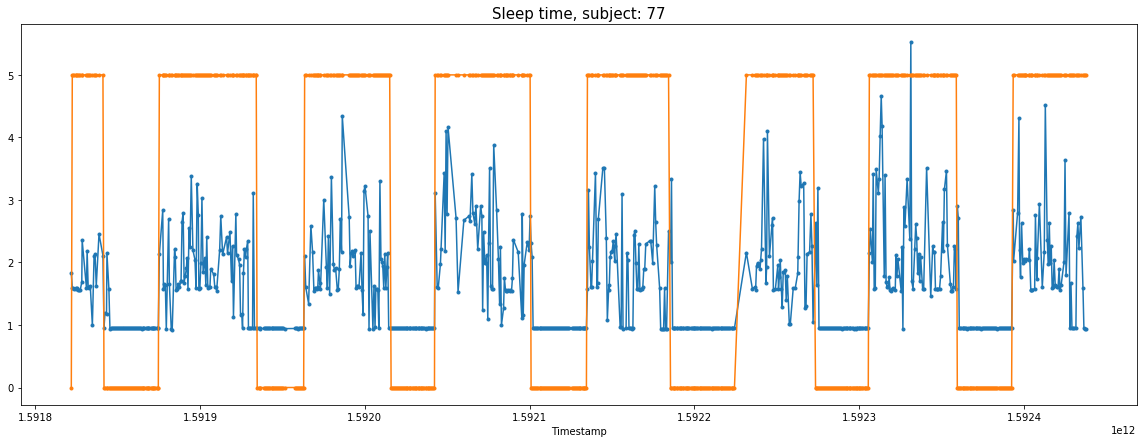

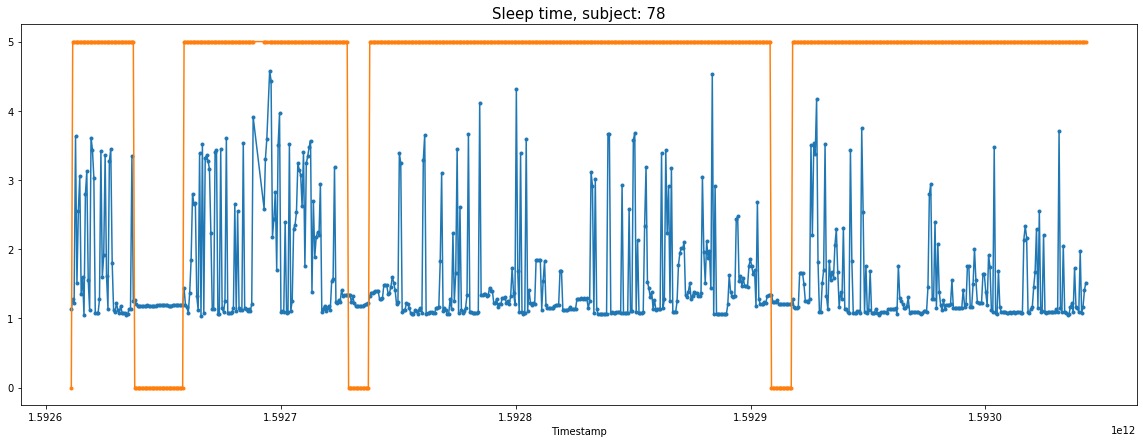

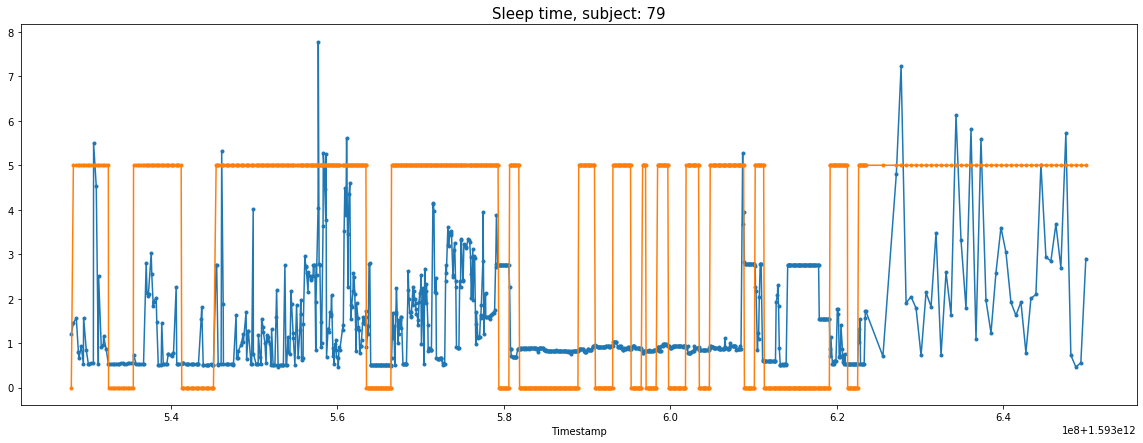

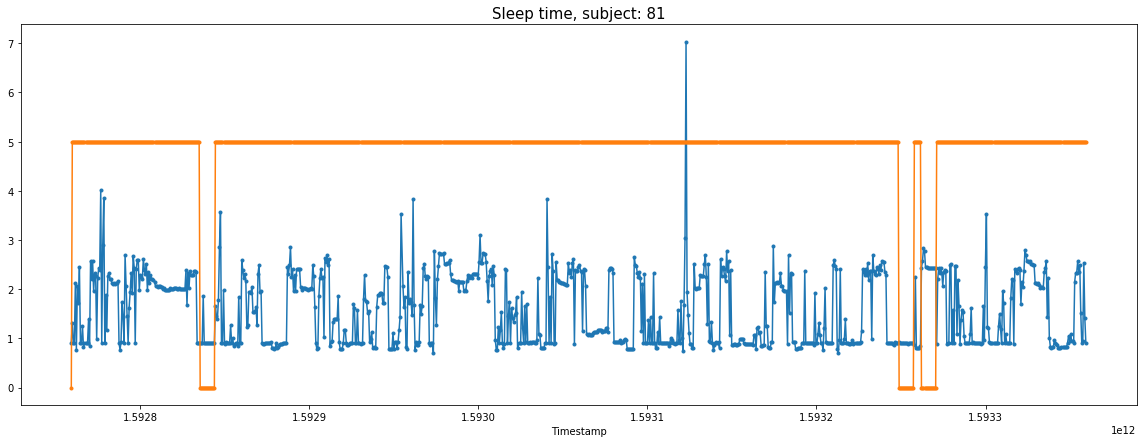

In [119]:
# Identify periods of sleep by periods of inactivity

# There's probably a way to do it with a mask, but just run a filter for now

def identify_sleep(tot_acc,w):
    # determine if person is sleeping 
    # tot_acc is a nsubj vector, and each tot_acc[nsubj] is a timeseries. Length varies with subj
    
    sleep_vec = np.empty_like(tot_acc); #return 0 if sleep, 5 (arbitrarily if not)
    for isubj in range(len(tot_acc)):
        sleep_vec[isubj] = np.ones_like(tot_acc[isubj])*5;
        kk = tot_acc[isubj];  #pdb.set_trace();
        i = 0; is_sleeping=0;
        while(i<len(kk)):
            tt = np.sum(np.abs(np.diff(kk[i:i+w],axis=0)));
            if (tt < 0.05):
                sleep_vec[isubj][i:i+w]=0;
                i=i+w;
                is_sleeping=1;
            else:
                if (is_sleeping==1):
                    sleep_vec[isubj][i:i+np.int(w/2)]=0; 
                    is_sleeping=0;
                i=i+1; 
    return(sleep_vec)

# which_subj=idx_d[0]

for which_subj in idx_d:
    f=plt.figure(figsize=(20,7))
    sleep_vec = identify_sleep(tot_acc,w=10);

    plt.plot(tt_[which_subj,0],tot_acc[which_subj],'.-',label='net acceleration'); plt.xlabel('Timestamp')
    plt.plot(tt_[which_subj,0],sleep_vec[which_subj],'.-',label='sleep vector'); 
    plt.title(f'Sleep time, subject: {which_subj:d}',fontsize=15);
    plt.savefig(f'Exploration/sleep_subj{which_subj:d}')
    plt.show();

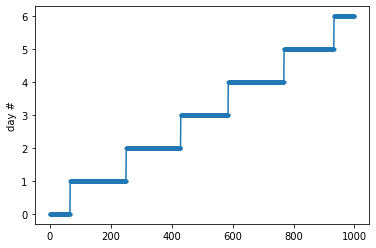

In [120]:
# Identify days from timestamp
def get_days(timestamp):
    # get day number from each timestamp
    
    start_time = timestamp[0];
    days = np.empty(shape=timestamp.shape);
    
    ms_to_day = 1000*60*60*24;
    curr_day = 0;
    i=0; 
    while (i<len(timestamp)):
        idx_next = np.where(timestamp > (start_time - ms_to_day))[0][-1]; 
        days[i:idx_next+1] = curr_day;
        
        curr_day = curr_day+1; #print(i)
        i = idx_next+1;
        start_time = timestamp[np.min([idx_next+1,len(timestamp)-1])];
    return days;
        
dumm = tt[3,0]; kk=get_days(dumm); plt.plot(kk,'.-'); plt.ylabel('day #'); 

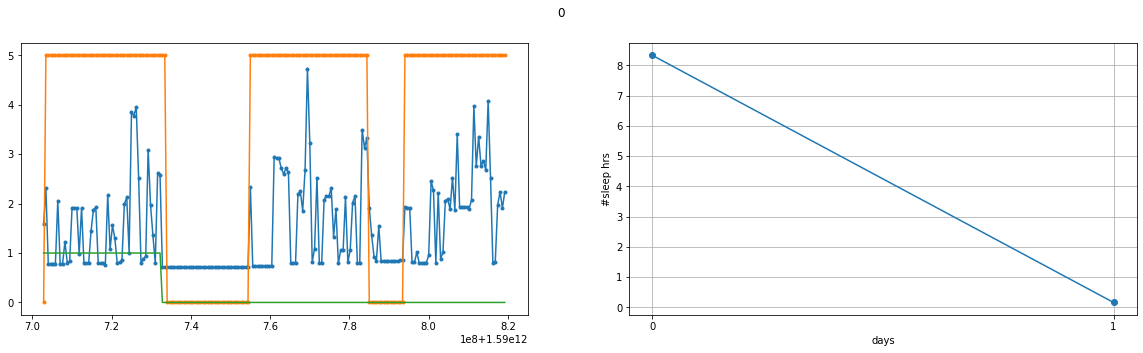

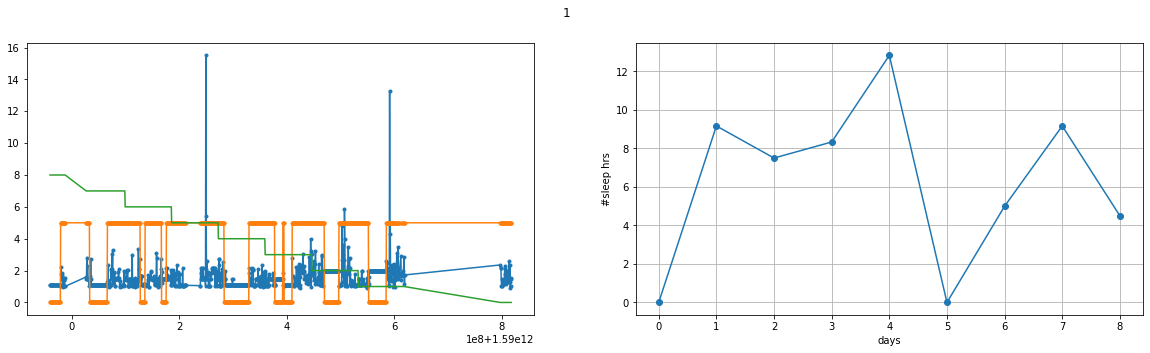

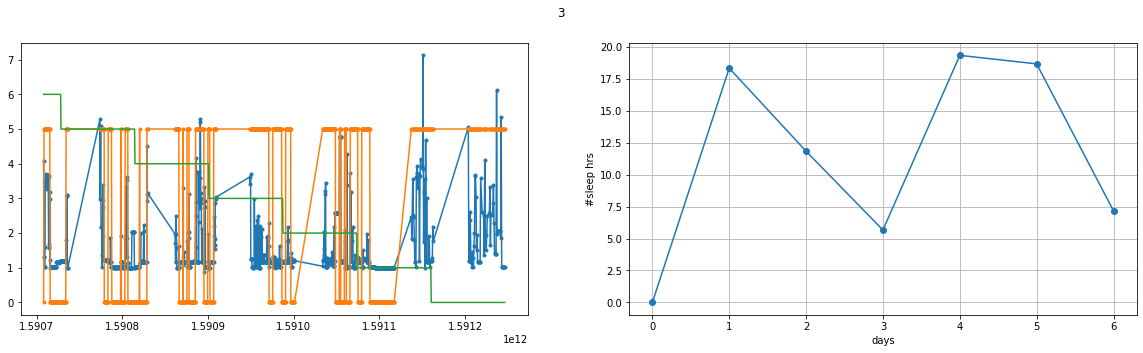

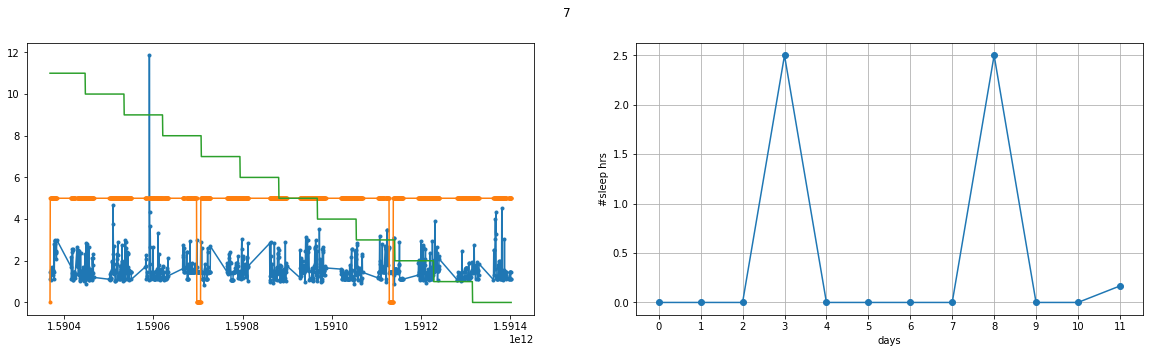

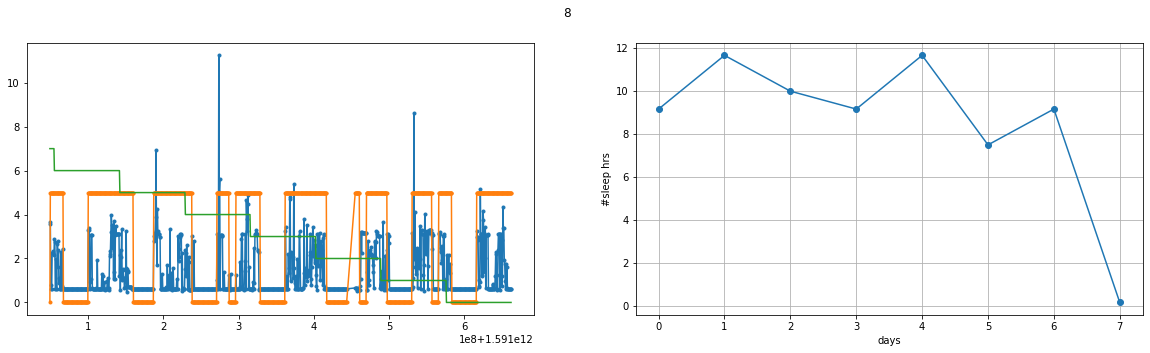

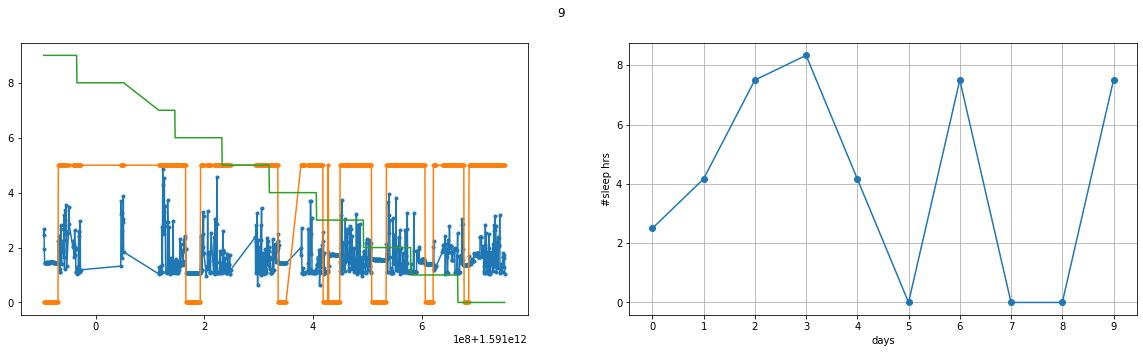

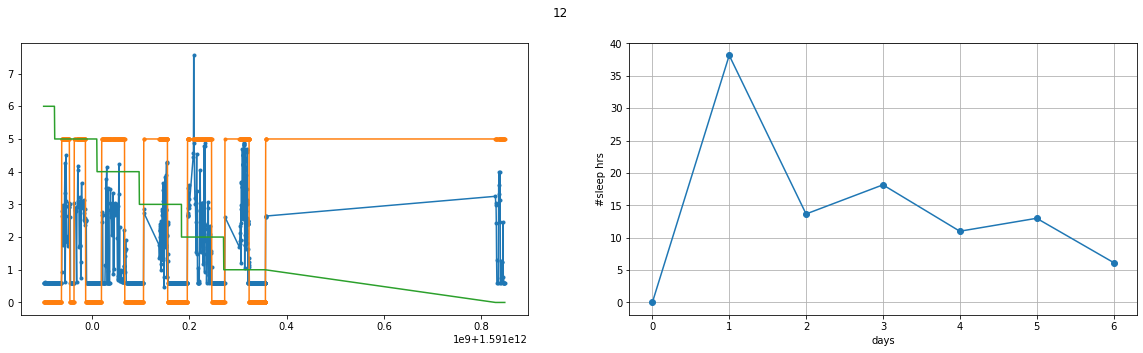

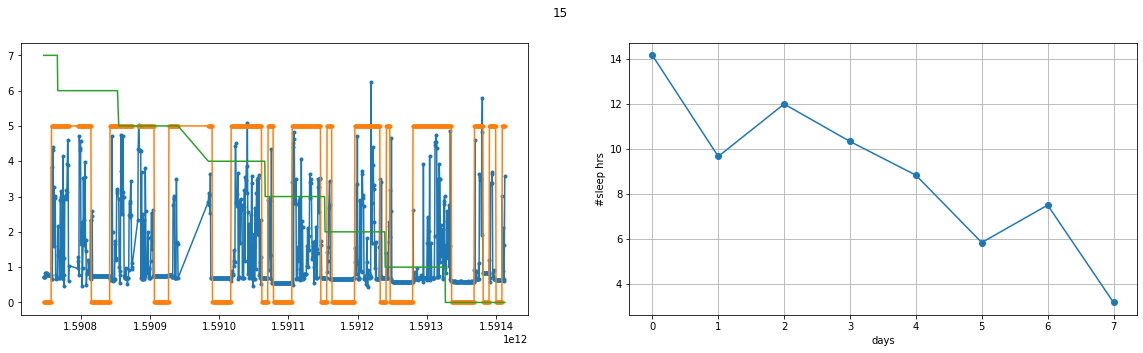

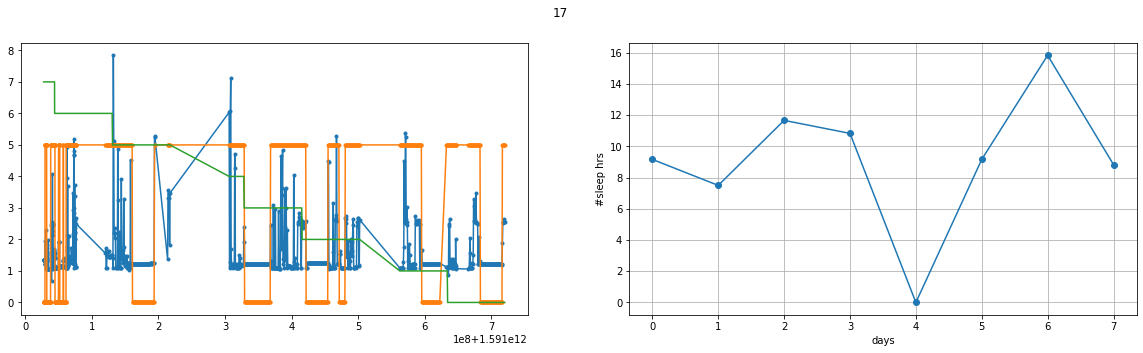

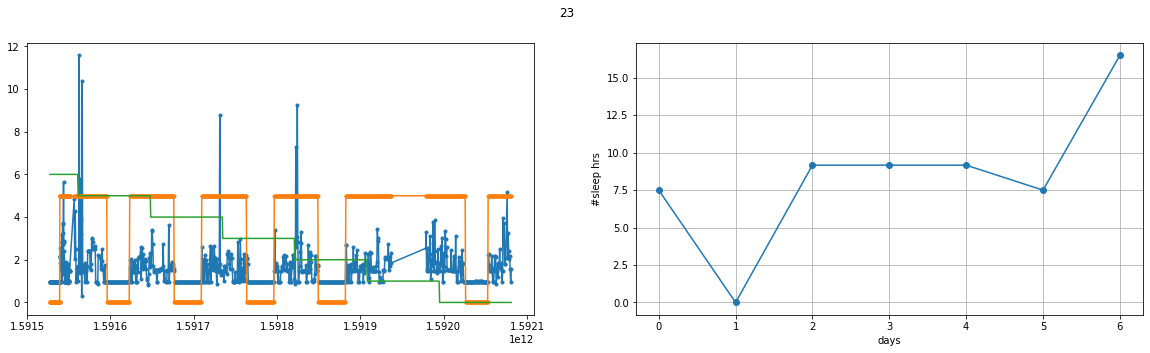

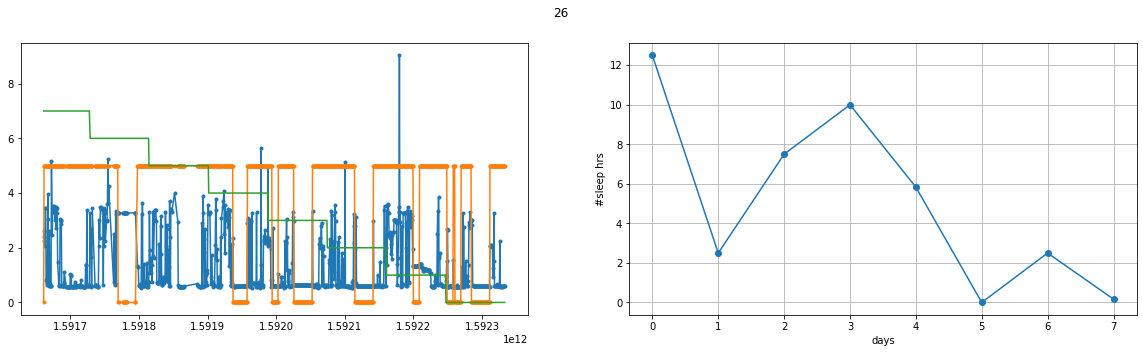

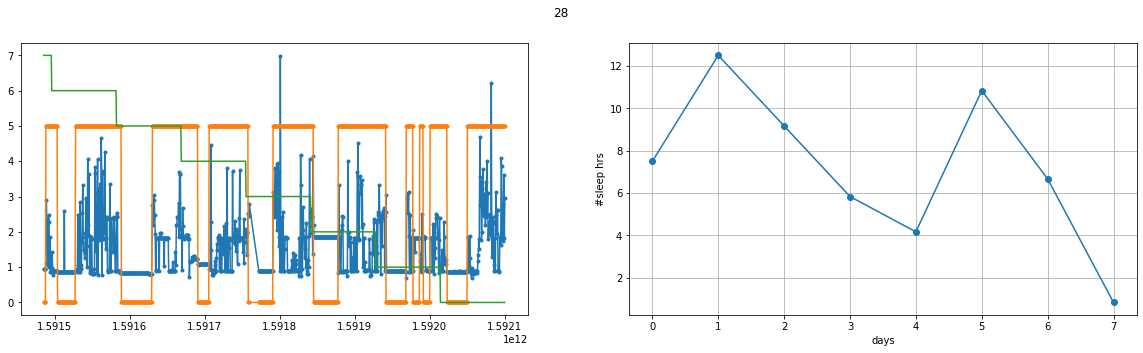

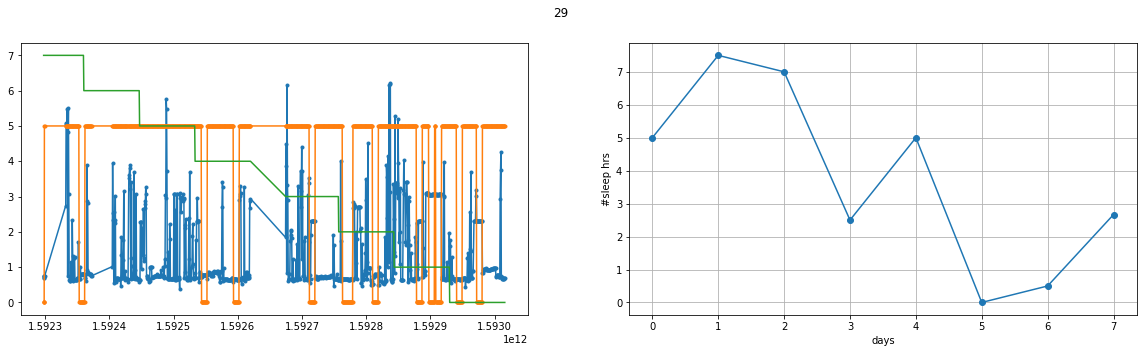

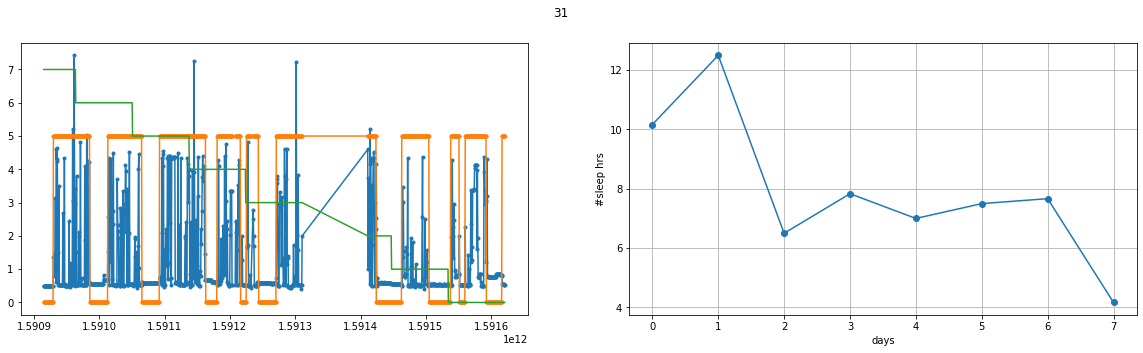

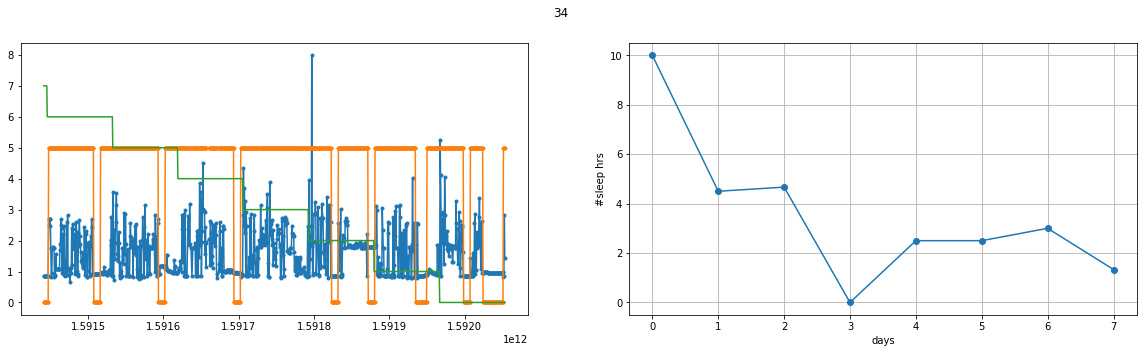

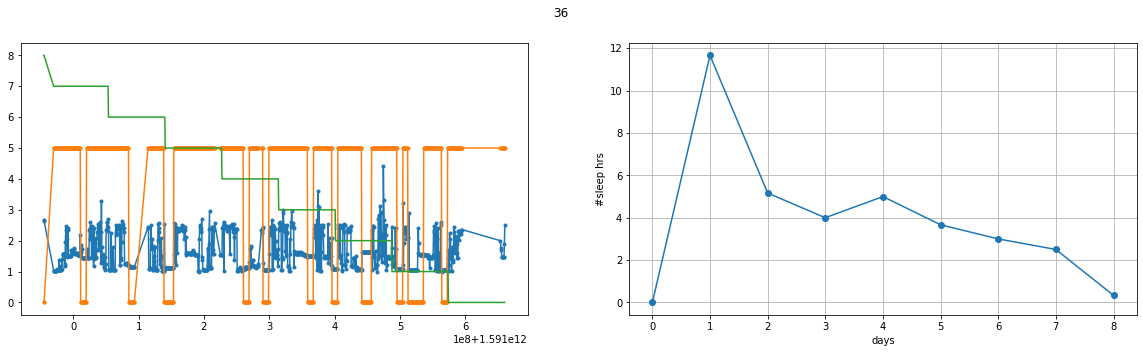

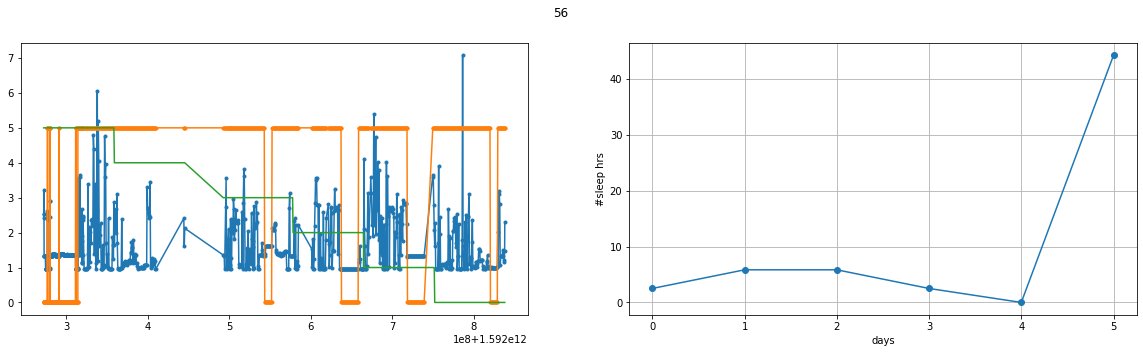

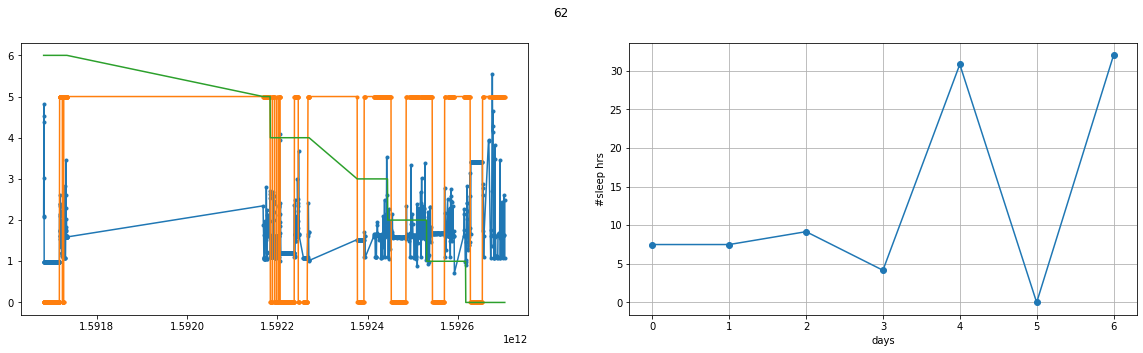

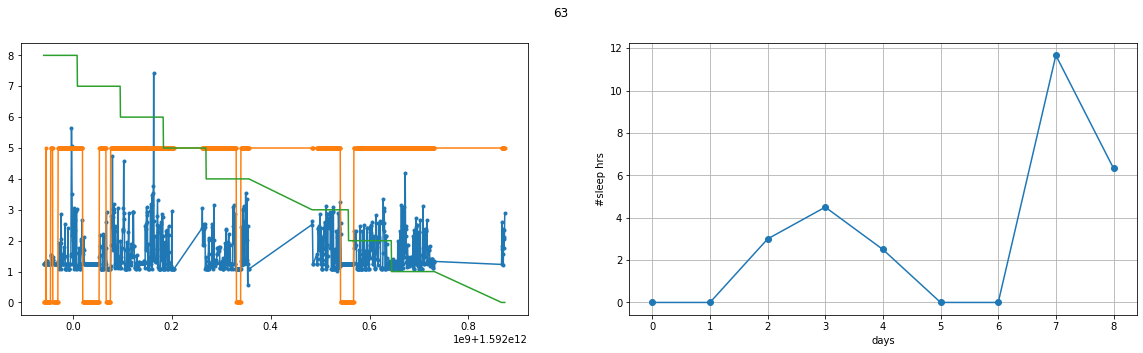

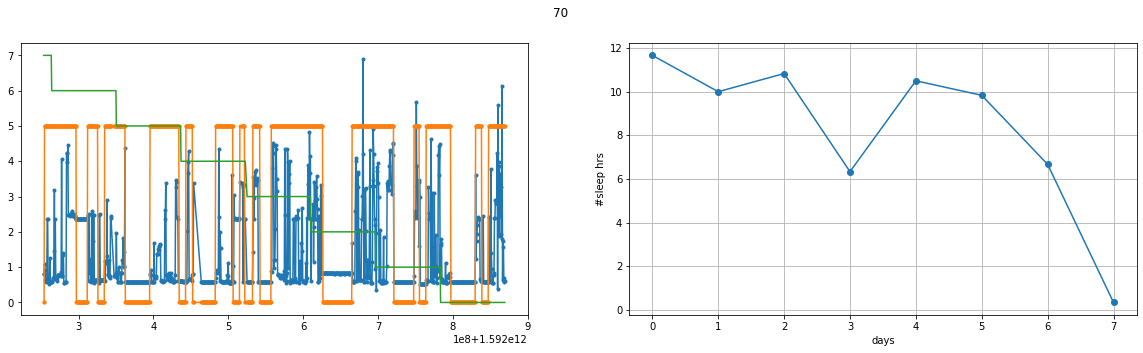

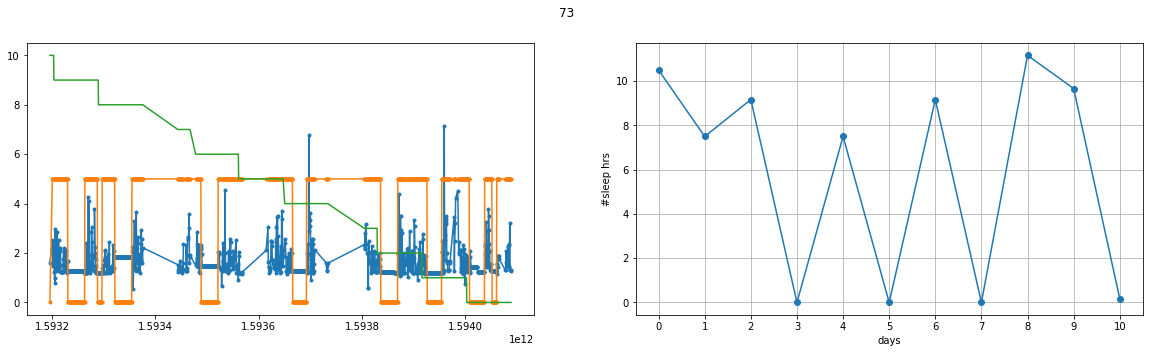

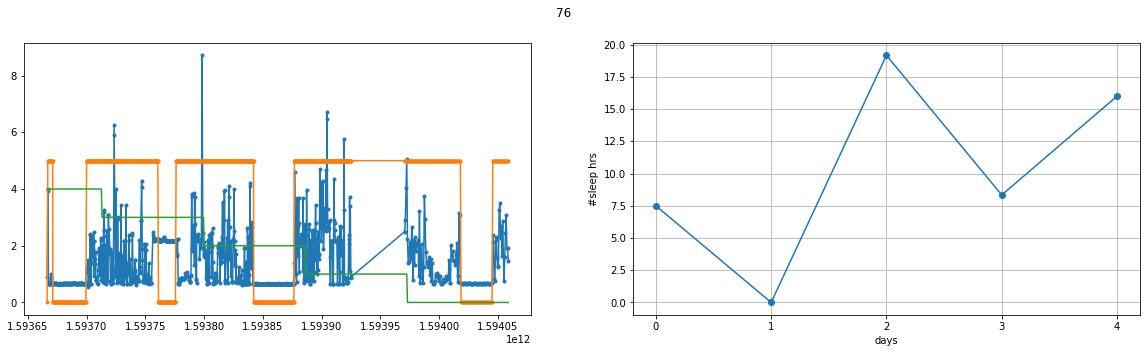

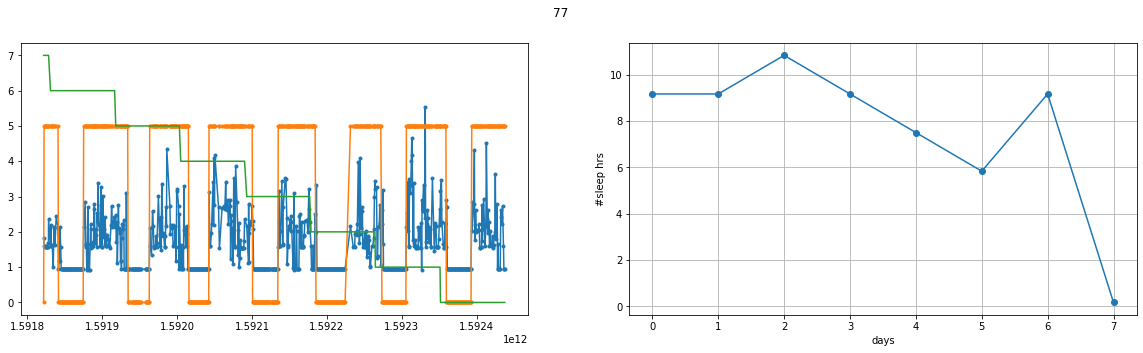

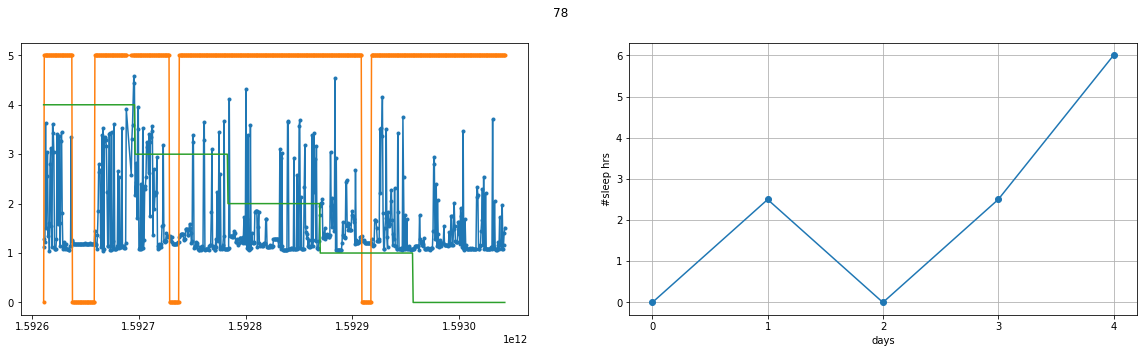

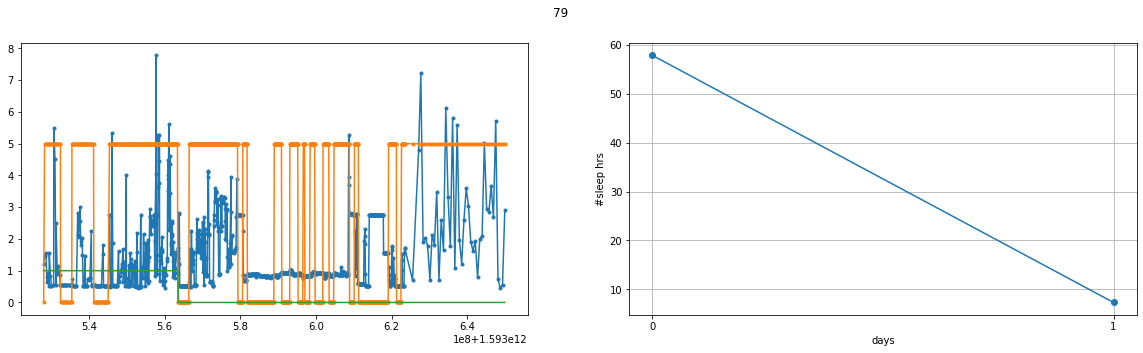

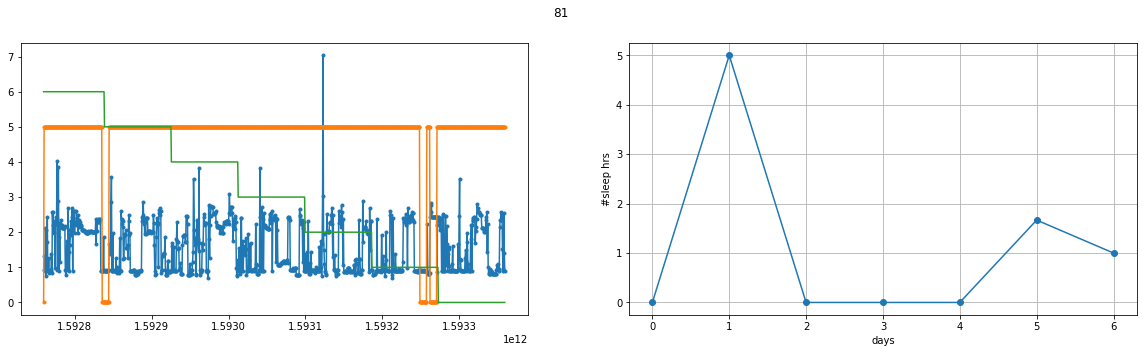

In [121]:
# Combine days and sleep vector for each participant
pass_sleep = identify_sleep(tot_acc,w=10);
pas = np.empty(shape=(nsubj,),dtype='object');

for i_subj in idx_d:
    day = get_days(tt_[i_subj,0]);
    ndays = np.unique(day); 
    pas[i_subj] = np.empty(shape=(len(ndays),))

    for counter, i_day in enumerate(ndays):
        pas[i_subj][counter] = np.sum(pass_sleep[i_subj][day == i_day] == 0)/6;

    f=plt.figure(figsize=(20,5))
    plt.subplot(121); plt.plot(tt_[i_subj,0],tot_acc[i_subj],'.-'); 
    plt.plot(tt_[i_subj,0],pass_sleep[i_subj],'.-'); 
    plt.plot(tt_[i_subj,0], day); 
    
    plt.subplot(122); plt.plot(pas[i_subj],'o-'); plt.grid(); plt.ylabel('#sleep hrs'); plt.xlabel('days'); plt.xticks(ndays)
    plt.suptitle(i_subj)
    plt.show();

### Get self-reported sleep time

100%|██████████| 82/82 [00:12<00:00,  6.56it/s]


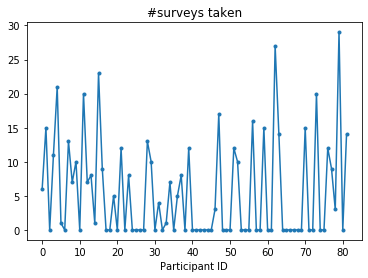

In [122]:
nsubj=82;
nsurvey = np.empty(shape=(nsubj),dtype='int')
for i in tqdm(range(nsubj),position=0, leave=True):#len(PARTICIPANTS_TWO['data'])):
    participant = PARTICIPANTS_TWO['data'][i]['id']; #First participant
    survey = LAMP.ActivityEvent.all_by_participant(participant)['data'];
    nsurvey[i]=len(survey);
plt.plot(nsurvey,'.-'); plt.title('#surveys taken'); plt.xlabel('Participant ID');
plt.show();

In [153]:
nsubj=82;
sequence = ['time of survey','sleep','stress','social anxiety','depression'];#,'lonely','Trouble staying awake',
#             'Eating problems','Tired','Trouble concentrating','Worrying constantly']
rep_active, rep_alcohol, rep_delusion = [np.empty(shape=(nsubj),dtype='object') for _ in range(3)];

for i_subj in tqdm(range(nsubj),position=0,leave=True):
    
#     rep_sleep[i_subj] = np.zeros(shape=(nsurvey[i_subj]),dtype='float')-2; #np.empty fills it with weird values
    rep_active[i_subj] = np.zeros(shape=(nsurvey[i_subj],len(sequence)),dtype='float');
    rep_alcohol[i_subj] = np.zeros(shape=(nsurvey[i_subj]),dtype='object');
    rep_delusion[i_subj] = np.zeros(shape=(nsurvey[i_subj],2),dtype='object');
    
    participant = PARTICIPANTS_TWO['data'][i_subj]['id']; #First participant
    survey = LAMP.ActivityEvent.all_by_participant(participant)['data'];
    
    for i_sur in range(nsurvey[i_subj]):
        #Reset these variables 
        nsleep, alcohol, delusion, hear_thot = ['-2' for _ in range(4)];
        stress, anxiety, depress = [-2 for _ in range(3)];
        time_of_survey = survey[i_sur]['timestamp'];
        if len(survey[i_sur]['temporal_slices'])>=8: #Sometimes temporal_slices is empty
            
            # Pick values from individual question nos.
            dicts = survey[i_sur]['temporal_slices'];
            
            for counter, ik in enumerate(dicts):
                if ik['item'] == 'I feel socially anxious':
                    anxiety = ik['value'];
                
            for counter, ik in enumerate(dicts):
                if ik['item'] == 'I feel down, depressed, or hopeless ':
                    depress = ik['value'];
            
            for counter, ik in enumerate(dicts):
                if ik['item'] == 'I feel lonely ':
                    lonely = ik['value'];
            
            for counter, ik in enumerate(dicts):
                if ik['item'] == 'How many hours of actual sleep did you get last night? ':
                    nsleep = ik['value'];
            
            for counter, ik in enumerate(dicts):
                if ik['item'] == 'I feel stressed':
                    stress = ik['value']
                    
            for counter, ik in enumerate(dicts):
                if ik['item'] == 'How often do you have a drink containing alcohol?':
                    alcohol = ik['value'];
                    
            for counter, ik in enumerate(dicts):
                if ik['item'] == 'I have been confused at times whether something I experienced was real or imaginary ':
                    delusion = ik['value']
          
            for counter, ik in enumerate(dicts):
                if ik['item'] == 'My thoughts are sometimes so strong that I can almost hear them':
                    hear_thot = ik['value'];
            # Put them all in a numeric format
            # Check about None 
            if anxiety is None:
                anxiety = -1;
            
            if depress is None:
                depress = -1;
            
            if stress is None:
                stress = -1;
            
            if nsleep is None: #for if data is not recorded
                nsleep = '-1';
            else: #Put this in a function
                nsleep=nsleep.strip();
                if len(nsleep)>=4 and nsleep[-1]=='s': #remove 'hours' or 'hrs' if they have it
                    if nsleep[-5:]=='hours':
                        nsleep = nsleep[0:-6];
                    elif nsleep[-3:]=='hrs':
                        nsleep = nsleep[0:-3];
            
            if len(nsleep)>=3 and ('-' in nsleep): #if nsleep=8-9, take average of first two chars
                idx_ = nsleep.find('-');
                nsleep = 0.5*(float((nsleep[0:idx_]).strip()) + float((nsleep[idx_+1:]).strip()));
                
            elif len(nsleep)>=3 and ('or' in nsleep): #if nsleep='1 or 2'
                idx_ = nsleep.find('or');
                nsleep = 0.5*(float((nsleep[0:idx_]).strip()) + float((nsleep[idx_+2:]).strip()));
            
            if alcohol is None:
                alcohol = '-1';
                
            if delusion is None:
                delusion = '-1';
                
            if hear_thot is None:
                hear_thot ='-1';
        print(str(i_subj) + ' ' + str(i_sur) + ' ' + hear_thot);    
 
        rep_active[i_subj][i_sur,] = [time_of_survey, float(nsleep), stress, anxiety, depress];
        rep_alcohol[i_subj][i_sur] = alcohol;
        rep_delusion[i_subj][i_sur,] = [delusion,hear_thot];

  1%|          | 1/82 [00:14<20:00, 14.82s/it]

0 0 No
0 1 No
0 2 No
0 3 No
0 4 No
0 5 No


  2%|▏         | 2/82 [00:21<16:22, 12.29s/it]

1 0 No
1 1 No
1 2 No
1 3 No
1 4 No
1 5 No
1 6 No
1 7 No
1 8 No
1 9 No
1 10 No
1 11 No
1 12 No
1 13 No
1 14 No


  5%|▍         | 4/82 [00:22<08:07,  6.25s/it]

3 0 No
3 1 No
3 2 -2
3 3 -2
3 4 -2
3 5 No
3 6 No
3 7 No
3 8 No
3 9 No
3 10 No


  6%|▌         | 5/82 [00:22<05:53,  4.60s/it]

4 0 No
4 1 No
4 2 No
4 3 No
4 4 No
4 5 No
4 6 No
4 7 No
4 8 No
4 9 No
4 10 No
4 11 No
4 12 No
4 13 No
4 14 No
4 15 No
4 16 No
4 17 No
4 18 No
4 19 No
4 20 No


  7%|▋         | 6/82 [00:23<04:09,  3.29s/it]

5 0 No


 10%|▉         | 8/82 [00:23<02:10,  1.77s/it]

7 0 No
7 1 No
7 2 No
7 3 -2
7 4 No
7 5 -2
7 6 No
7 7 No
7 8 -2
7 9 No
7 10 No
7 11 -2
7 12 No


 11%|█         | 9/82 [00:23<01:36,  1.33s/it]

8 0 No
8 1 No
8 2 No
8 3 No
8 4 No
8 5 No
8 6 No


 12%|█▏        | 10/82 [00:24<01:14,  1.04s/it]

9 0 -2
9 1 Maybe
9 2 No
9 3 No
9 4 No
9 5 No
9 6 No
9 7 No
9 8 No
9 9 No


 15%|█▍        | 12/82 [00:24<00:46,  1.49it/s]

11 0 No
11 1 No
11 2 No
11 3 No
11 4 No
11 5 No
11 6 No
11 7 No
11 8 No
11 9 No
11 10 No
11 11 No
11 12 No
11 13 No
11 14 No
11 15 No
11 16 No
11 17 No
11 18 -2
11 19 -2


 16%|█▌        | 13/82 [00:25<00:38,  1.78it/s]

12 0 No
12 1 No
12 2 No
12 3 No
12 4 Maybe
12 5 Maybe
12 6 No


 17%|█▋        | 14/82 [00:28<01:28,  1.31s/it]

13 0 No
13 1 No
13 2 No
13 3 No
13 4 No
13 5 No
13 6 No
13 7 No


 18%|█▊        | 15/82 [00:28<01:05,  1.02it/s]

14 0 Yes


 20%|█▉        | 16/82 [00:28<00:52,  1.26it/s]

15 0 -2
15 1 No
15 2 -2
15 3 No
15 4 No
15 5 -2
15 6 No
15 7 -2
15 8 No
15 9 -2
15 10 No
15 11 No
15 12 No
15 13 -2
15 14 No
15 15 -2
15 16 No
15 17 No
15 18 No
15 19 -2
15 20 -2
15 21 No
15 22 No


 21%|██        | 17/82 [00:29<00:46,  1.40it/s]

16 0 No
16 1 No
16 2 No
16 3 No
16 4 -2
16 5 -2
16 6 -2
16 7 No
16 8 No


 26%|██▌       | 21/82 [00:30<00:21,  2.83it/s]

19 0 No
19 1 No
19 2 No
19 3 No
19 4 No


 27%|██▋       | 22/82 [00:30<00:19,  3.05it/s]

21 0 No
21 1 No
21 2 No
21 3 No
21 4 No
21 5 No
21 6 No
21 7 No
21 8 No
21 9 No
21 10 No
21 11 No


 29%|██▉       | 24/82 [00:31<00:16,  3.44it/s]

23 0 No
23 1 No
23 2 No
23 3 No
23 4 No
23 5 No
23 6 No
23 7 No


 35%|███▌      | 29/82 [00:33<00:21,  2.50it/s]

28 0 -2
28 1 No
28 2 No
28 3 -2
28 4 No
28 5 No
28 6 No
28 7 No
28 8 No
28 9 No
28 10 No
28 11 No
28 12 No


 37%|███▋      | 30/82 [00:33<00:20,  2.55it/s]

29 0 No
29 1 No
29 2 No
29 3 No
29 4 No
29 5 No
29 6 -2
29 7 No
29 8 No
29 9 No


 39%|███▉      | 32/82 [00:34<00:16,  2.99it/s]

31 0 No
31 1 No
31 2 No
31 3 No


 41%|████▏     | 34/82 [00:34<00:13,  3.48it/s]

33 0 Yes


 43%|████▎     | 35/82 [00:34<00:13,  3.48it/s]

34 0 No
34 1 No
34 2 No
34 3 No
34 4 No
34 5 No
34 6 No


 45%|████▌     | 37/82 [00:35<00:12,  3.56it/s]

36 0 No
36 1 No
36 2 No
36 3 No
36 4 No


 46%|████▋     | 38/82 [00:35<00:12,  3.57it/s]

37 0 No
37 1 No
37 2 No
37 3 No
37 4 No
37 5 No
37 6 No
37 7 No


 49%|████▉     | 40/82 [00:36<00:11,  3.68it/s]

39 0 -2
39 1 No
39 2 -2
39 3 Yes
39 4 Yes
39 5 No
39 6 No
39 7 No
39 8 No
39 9 Yes
39 10 No
39 11 No


 57%|█████▋    | 47/82 [00:37<00:07,  4.53it/s]

46 0 No
46 1 Yes
46 2 No


 59%|█████▊    | 48/82 [00:38<00:08,  4.11it/s]

47 0 -2
47 1 -2
47 2 No
47 3 -2
47 4 -2
47 5 No
47 6 -2
47 7 -2
47 8 No
47 9 -2
47 10 -2
47 11 No
47 12 No
47 13 No
47 14 No
47 15 No
47 16 No


 63%|██████▎   | 52/82 [00:41<00:20,  1.44it/s]

51 0 -2
51 1 No
51 2 -2
51 3 No
51 4 -2
51 5 No
51 6 -2
51 7 No
51 8 No
51 9 No
51 10 No
51 11 No


 65%|██████▍   | 53/82 [00:41<00:16,  1.78it/s]

52 0 -2
52 1 -2
52 2 No
52 3 -2
52 4 -2
52 5 No
52 6 No
52 7 No
52 8 No
52 9 No


 70%|██████▉   | 57/82 [00:42<00:08,  2.79it/s]

56 0 Yes
56 1 -2
56 2 Yes
56 3 -2
56 4 Yes
56 5 -2
56 6 Yes
56 7 -2
56 8 No
56 9 -2
56 10 Yes
56 11 Yes
56 12 Yes
56 13 Yes
56 14 Yes
56 15 Yes


 73%|███████▎  | 60/82 [00:43<00:06,  3.53it/s]

59 0 -2
59 1 -2
59 2 No
59 3 -2
59 4 -2
59 5 No
59 6 -2
59 7 -2
59 8 No
59 9 -2
59 10 -2
59 11 No
59 12 No
59 13 No
59 14 No


 77%|███████▋  | 63/82 [00:44<00:04,  3.90it/s]

62 0 -2
62 1 -2
62 2 -2
62 3 No
62 4 -2
62 5 -2
62 6 No
62 7 -2
62 8 -2
62 9 -2
62 10 No
62 11 -2
62 12 -2
62 13 No
62 14 -2
62 15 -2
62 16 No
62 17 -2
62 18 -2
62 19 -2
62 20 -2
62 21 -2
62 22 -2
62 23 -2
62 24 -2
62 25 -2
62 26 No


 78%|███████▊  | 64/82 [00:44<00:04,  3.92it/s]

63 0 -2
63 1 -2
63 2 No
63 3 -2
63 4 -2
63 5 No
63 6 -2
63 7 -2
63 8 No
63 9 No
63 10 No
63 11 No
63 12 No
63 13 No


 87%|████████▋ | 71/82 [00:47<00:03,  3.27it/s]

70 0 -2
70 1 -2
70 2 No
70 3 -2
70 4 No
70 5 -2
70 6 -2
70 7 No
70 8 -2
70 9 No
70 10 -2
70 11 No
70 12 No
70 13 No
70 14 No


 90%|█████████ | 74/82 [00:47<00:02,  3.41it/s]

73 0 Yes
73 1 Yes
73 2 Yes
73 3 Yes
73 4 Yes
73 5 Yes
73 6 Yes
73 7 Yes
73 8 Yes
73 9 Yes
73 10 Yes
73 11 Yes
73 12 Yes
73 13 Yes
73 14 -2
73 15 Yes
73 16 Yes
73 17 Yes
73 18 Yes
73 19 -2


 94%|█████████▍| 77/82 [00:48<00:01,  3.68it/s]

76 0 -2
76 1 -2
76 2 -2
76 3 No
76 4 -2
76 5 No
76 6 -2
76 7 -2
76 8 No
76 9 No
76 10 -2
76 11 -1


 95%|█████████▌| 78/82 [00:48<00:01,  3.89it/s]

77 0 No
77 1 -2
77 2 -2
77 3 -2
77 4 -2
77 5 No
77 6 No
77 7 No
77 8 No


 96%|█████████▋| 79/82 [00:49<00:00,  3.84it/s]

78 0 No
78 1 No
78 2 -2


 98%|█████████▊| 80/82 [00:49<00:00,  3.19it/s]

79 0 -2
79 1 -2
79 2 No
79 3 -2
79 4 -2
79 5 No
79 6 -2
79 7 -2
79 8 No
79 9 -2
79 10 -2
79 11 No
79 12 -2
79 13 -2
79 14 No
79 15 -2
79 16 -2
79 17 No
79 18 -2
79 19 -2
79 20 No
79 21 -2
79 22 -2
79 23 No
79 24 -2
79 25 -2
79 26 No
79 27 No
79 28 No


100%|██████████| 82/82 [00:50<00:00,  2.49it/s]

81 0 No
81 1 -2
81 2 No
81 3 -2
81 4 No
81 5 No
81 6 -2
81 7 No
81 8 -2
81 9 No
81 10 -2
81 11 No
81 12 -2
81 13 No


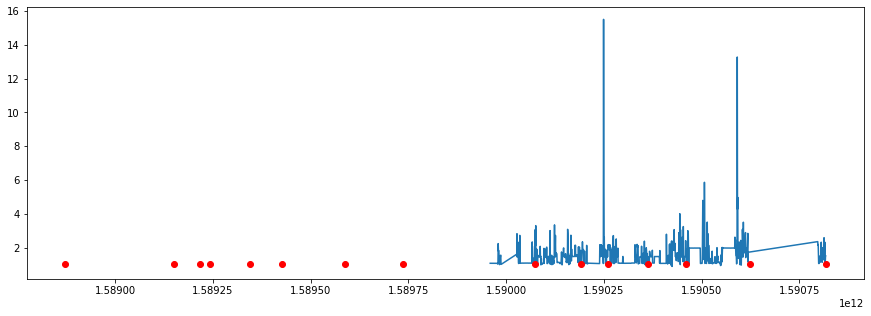

In [124]:
#Combine reported sleep time and passive data sleep time
i_subj=1;
f=plt.figure(figsize=(15,5))
plt.plot(tt_[i_subj,0],tot_acc[i_subj]);
for i_sur in range(nsurvey[i_subj]):
     plt.plot(rep_active[i_subj][i_sur][0],1,'o-',color='red')

In [154]:
# Code delusion 
def code_delusion(rep_delusion):
    n = len(rep_delusion);
    code_rep_delusion = np.empty_like(rep_delusion);
    
    switcher = {
        '-2':-2,
        'No':0,
        'Yes':1,
        'Maybe':2
    }
    
    for i_subj in range(n):
        code_rep_delusion[i_subj] = np.zeros(shape=(len(rep_delusion[i_subj]),2))-3;
        for i_sur in range(len(rep_delusion[i_subj])):
            code_rep_delusion[i_subj][i_sur,0] = switcher.get(rep_delusion[i_subj][i_sur][0],-3);
            code_rep_delusion[i_subj][i_sur,1] = switcher.get(rep_delusion[i_subj][i_sur][1],-3);
            
    return code_rep_delusion

rep_delusion_all = np.array([]).reshape(0,2);
kk = code_delusion(rep_delusion);
for i_subj in range(nsubj):
    rep_delusion_all = np.concatenate((rep_delusion_all, kk[i_subj]))

# print(rep_delusion_all.shape)
# print(rep_delusion_all)

In [155]:
# Code typical alcohol consumption
def code_typical_alcohol(rep_alcohol):
    n = len(rep_alcohol);
    code_rep_alcohol = np.empty_like(rep_alcohol);
    
    switcher = {
        '-1': -1,
        '-2': -2,
        'Never': 0,
        'Monthly or less': 1,
        '2-4 times a month': 2,
        '2-3 times a week': 3,
        '4 or more times a week': 4
    }
    for i_subj in range(n):
        code_rep_alcohol[i_subj] = np.zeros(shape=(len(rep_alcohol[i_subj])))-3;
        for i_sur in range(len(rep_alcohol[i_subj])):
            code_rep_alcohol[i_subj][i_sur] = switcher.get(rep_alcohol[i_subj][i_sur],-3);
    
    return code_rep_alcohol

rep_alcohol_all=np.array([]);
kk = code_typical_alcohol(rep_alcohol);
for i_subj in range(nsubj):
    rep_alcohol_all = np.concatenate((rep_alcohol_all, kk[i_subj]));
print(rep_alcohol_all.shape)

(453,)


/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


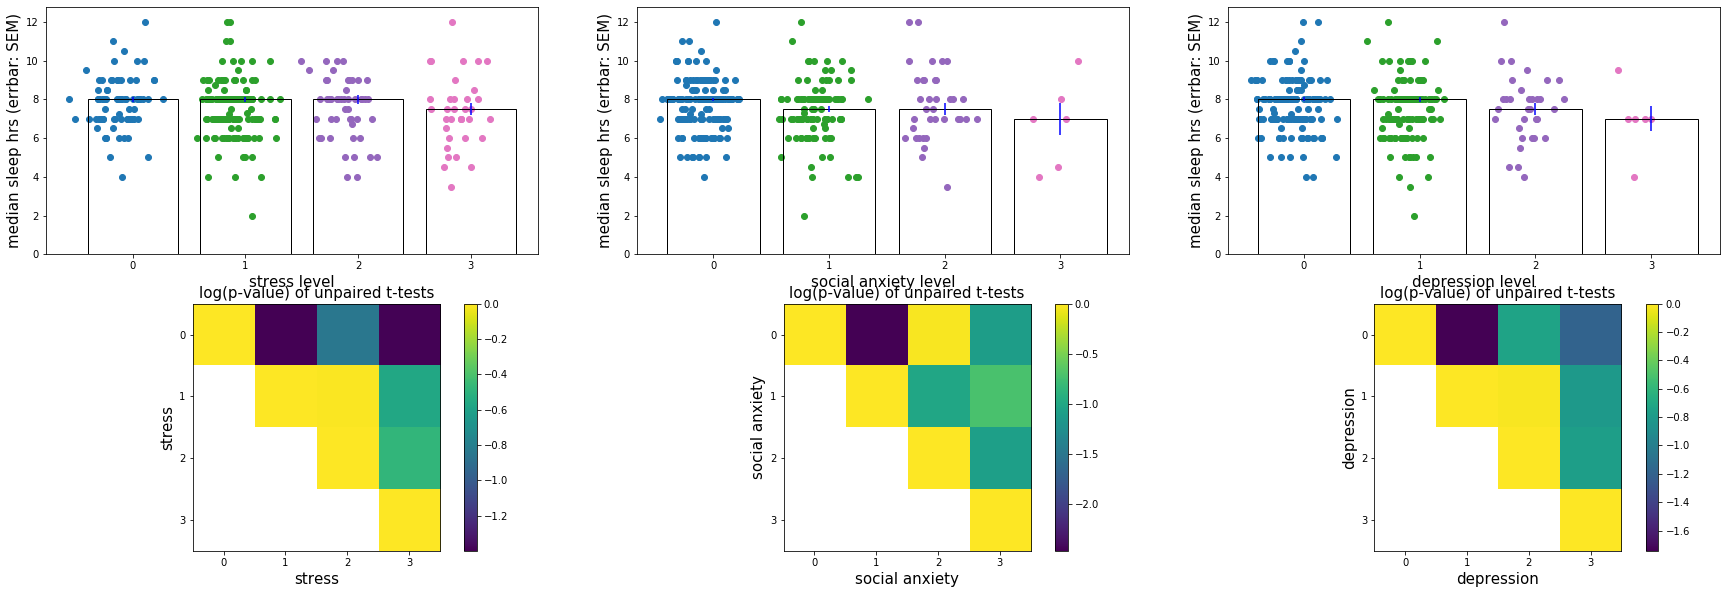

In [148]:
# Plot stress value vs hrs of sleep
rep_active_all = np.array([]).reshape(0,len(sequence));
for i_subj in range(nsubj):
    rep_active_all = np.concatenate((rep_active_all,rep_active[i_subj]));

p_val = np.zeros(shape=(4,4,3));
f = plt.figure(figsize=(30,10));
for iseq in range(2,len(sequence)):
    
    # bars for each stress/anxiety/depression level
    plt.subplot(2,3,iseq-1)
    for i in range(4):
        idx=(rep_active_all[:,iseq]==i) & (rep_active_all[:,1]>0);
        plt.scatter(np.ones_like(rep_active_all[idx,0])*i+(np.random.normal(-0.1,0.15,len(rep_active_all[idx,1]))),
                    rep_active_all[idx,1]);
        plt.bar(i,np.median(rep_active_all[idx,1]), fill=False);
        plt.errorbar(i,np.median(rep_active_all[idx,1]), 
                     np.std(rep_active_all[idx,1])/np.sqrt(len(rep_active_all[idx,1])),color='blue')
    plt.ylabel('median sleep hrs (errbar: SEM)',fontsize=15); 
    plt.xlabel(f'{sequence[iseq]} level',fontsize=15); plt.xticks([0,1,2,3])
    
    # unpaired t-test b/w each pair 
    for i in range(4):
        for j in range(i,4):
            idx_i = (rep_active_all[:,iseq]==(i)) & (rep_active_all[:,1]>0);
            idx_j = (rep_active_all[:,iseq]==(j)) & (rep_active_all[:,1]>0);
            t,p = stats.ttest_ind(rep_active_all[idx_i,1],rep_active_all[idx_j,1],equal_var=False);
            p_val[i,j,iseq-2] = p;
#         pdb.set_trace();
    
    plt.subplot(2,3,iseq+2); plt.imshow(np.log(p_val[:,:,iseq-2])); plt.colorbar(); 
    plt.yticks(range(4)); plt.xticks(range(4)); 
    plt.ylabel(sequence[iseq],fontsize=15); plt.xlabel(sequence[iseq],fontsize=15); 
    plt.title('log(p-value) of unpaired t-tests',fontsize=15);    
plt.show();



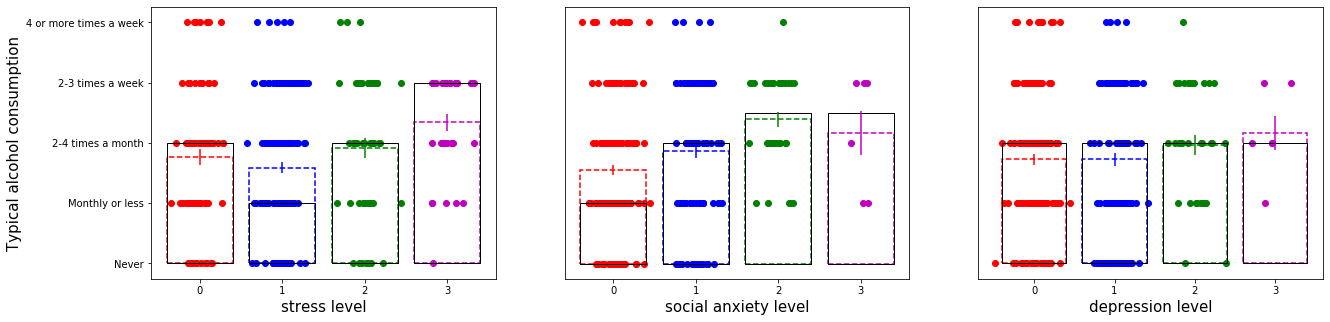

In [149]:
# Plot average alcohol with stress/anxiety/depression

color_list =['r','b','g','m']
f=plt.figure(figsize=(21,5));
for iseq in range(2,len(sequence)):
    plt.subplot(1,3,iseq-1)
    for i in range(4):
        idx=(rep_active_all[:,iseq]==i) & (rep_alcohol_all>=0);
        plt.scatter(np.ones_like(rep_alcohol_all[idx])*i+(0.15*np.random.normal(0,1,len(rep_alcohol_all[idx]))),
                    rep_alcohol_all[idx],color=color_list[i]);
        plt.bar(i,np.mean(rep_alcohol_all[idx]),edgecolor=color_list[i],linestyle='--',linewidth=1.5,fill=False);
        plt.bar(i,np.median(rep_alcohol_all[idx]),fill=False);
        plt.errorbar(i,np.mean(rep_alcohol_all[idx]), 
                     np.std(rep_alcohol_all[idx])/np.sqrt(len(rep_alcohol_all[idx])),linewidth=1.5,color=color_list[i])
        
    plt.xlabel(f'{sequence[iseq]} level',fontsize=15); plt.xticks([0,1,2,3])
    if iseq ==2:
        plt.ylabel('Typical alcohol consumption',fontsize=15); 
        plt.yticks(range(5),['Never','Monthly or less','2-4 times a month','2-3 times a week','4 or more times a week']); 
    else:
        plt.yticks([]); 
plt.show();

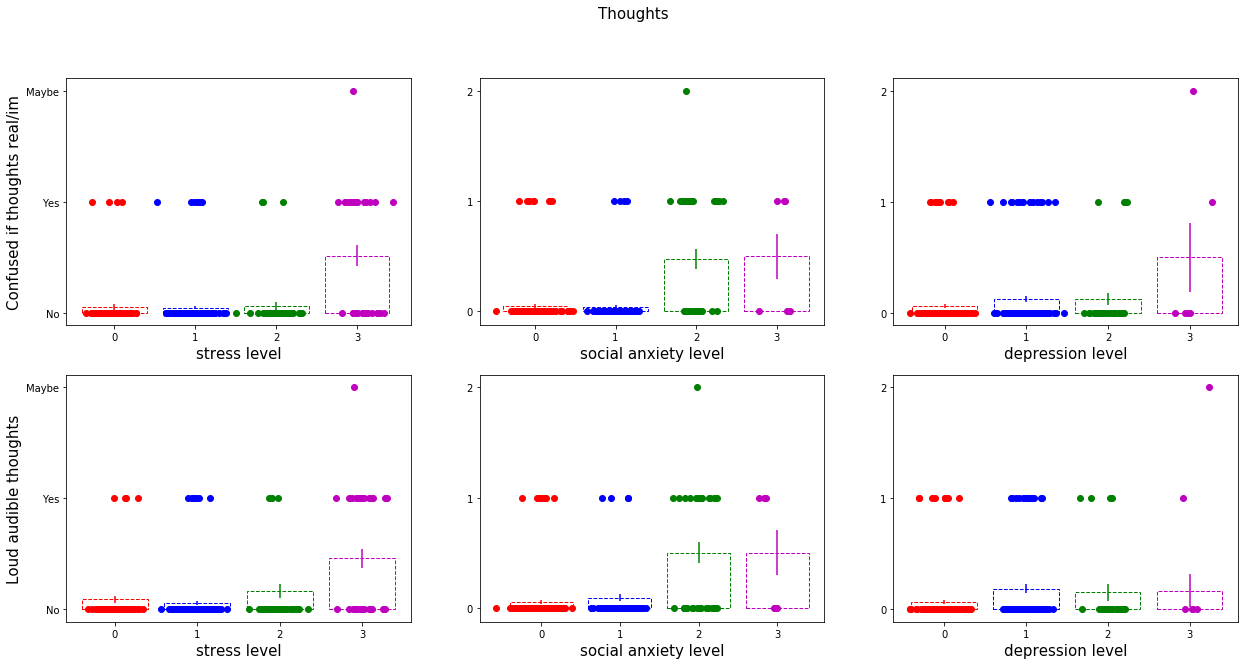

In [161]:
# Delusional thoughts vs. stress/anxiety/depression
kind_thoughts = ['Confused if thoughts real/im','Loud audible thoughts']
f=plt.figure(figsize=(21,10));
for iseq in range(2,len(sequence)):
    
    for irow in range(len(rep_delusion_all[0])):
        plt.subplot(2,3,iseq-1+irow*3); 
        for i in range(4):
            # Row 1: Real/Imaginary, Row
            idx=(rep_active_all[:,iseq]==i) & (rep_delusion_all[:,irow]>=0);

            plt.scatter(np.random.normal(i,0.15,len(rep_delusion_all[idx,irow])), 
                        rep_delusion_all[idx,0],color=color_list[i]);
            plt.bar(i,np.mean(rep_delusion_all[idx,irow]),linestyle='--',edgecolor=color_list[i],fill=False);

            plt.errorbar(i,np.mean(rep_delusion_all[idx,irow]),
                         np.std(rep_delusion_all[idx,irow])/np.sqrt(len(rep_delusion_all[idx,irow])),color=color_list[i]);

        plt.xlabel(f'{sequence[iseq]} level',fontsize=15); plt.xticks([0,1,2,3])
        if (iseq == 2):
            plt.ylabel(kind_delusion[irow],fontsize=15); plt.yticks([0,1,2],['No','Yes','Maybe']);
        else:
            plt.yticks([0,1,2]);
            
plt.suptitle('Thoughts',fontsize=15); plt.show()

##### Query responses are limtied to 1000 entries. To access more data—or to query during a specific time range—you must use the "_to" and "from" parameters

Text(0, 0.5, 'std of ratio')

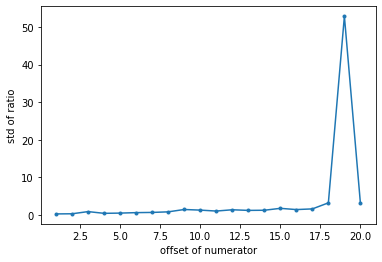

In [33]:
NN=10000;
kk=np.empty(shape=(20,))
for i in range(20):
    a1=np.random.normal(i+1,1,NN);
    a2=np.random.normal(4,1,NN);
    kk[i] = np.std(np.divide(a1,a2));
    
plt.plot(range(1,21),kk,'.-'); plt.xlabel('offset of numerator'); plt.ylabel('std of ratio')

In [28]:
# '_from' and 'to' are UNIX timestamps
participant_accel_tr = LAMP.SensorEvent.all_by_participant(participant, origin="lamp.accelerometer", _from='1590825203977', to='1591037604683')
participant_accel_tr['data'][:5]

[{'timestamp': 1591037004631,
  'sensor': 'lamp.accelerometer',
  'data': {'x': -0.0043182373046875,
   'y': 0.0084381103515625,
   'z': -1.0113525390625}},
 {'timestamp': 1591036404658,
  'sensor': 'lamp.accelerometer',
  'data': {'x': -0.000518798828125,
   'y': -0.0105133056640625,
   'z': -1.009490966796875}},
 {'timestamp': 1591035803625,
  'sensor': 'lamp.accelerometer',
  'data': {'x': 0.0002288818359375,
   'y': -0.0070648193359375,
   'z': -1.0112762451171875}},
 {'timestamp': 1591035204684,
  'sensor': 'lamp.accelerometer',
  'data': {'x': 0.001617431640625,
   'y': -0.9739990234375,
   'z': -0.2412261962890625}},
 {'timestamp': 1591034604670,
  'sensor': 'lamp.accelerometer',
  'data': {'x': 0.0016632080078125,
   'y': -0.9756927490234375,
   'z': -0.238189697265625}}]

## Query surveys

##### Surveys are ActivityEvents, with each survey type defined as an Activity 

##### 'duration' is the survey completion time, in ms

##### 'activity' is the Activity id

##### 'temporal_slices' contains responses for each survey question

In [644]:
LAMP.ActivityEvent.all_by_participant(participant)['data'][0]

{'timestamp': 1591550369000,
 'duration': 39000,
 'activity': 'QWN0aXZpdHk6MDoxMDkyODow',
 'static_data': {},
 'temporal_slices': [{'item': 'I feel socially anxious',
   'value': 0,
   'type': 'valid',
   'duration': 2000,
   'level': None},
  {'item': 'I feel down, depressed, or hopeless ',
   'value': 0,
   'type': 'valid',
   'duration': 2000,
   'level': None},
  {'item': 'In general, I would say my health is',
   'value': 'Very Good',
   'type': 'valid',
   'duration': 2000,
   'level': None},
  {'item': 'Compared to one year ago, I would rate my health in now as ',
   'value': 'About the same',
   'type': 'valid',
   'duration': 5000,
   'level': None},
  {'item': 'I feel lonely ',
   'value': 0,
   'type': 'valid',
   'duration': 1000,
   'level': None},
  {'item': 'I have been confused at times whether something I experienced was real or imaginary ',
   'value': 'No',
   'type': 'valid',
   'duration': 2000,
   'level': None},
  {'item': 'My thoughts are sometimes so strong tha